# Change orientation with LinearRegressor

## Reproducibility
Setting 42 as the random seed for all sources of randomness.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
RANDOM_SEED = 42

def set_reproducibility(seed: int):
    """
    Set the same random seed to different sources of randomness

    :param seed: random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_reproducibility(RANDOM_SEED)

## Libraries installation and costant definition

In [3]:
%%capture
!pip install face-recognition

In [4]:
import matplotlib.pyplot as plt
import cv2
import face_recognition
import math
import pandas as pd
import sys

from skimage import color
import imutils

from google.colab import files
import gdown
import re

import skimage.io
import skimage.filters
import scipy
from sklearn.linear_model import LinearRegression

import imageio
from IPython.display import Image
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from numpy.linalg import norm
import itertools

import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*10)])
  except RuntimeError as e:
    print(e)

constant definition

In [6]:
FACE_SIZE = (64, 64)
FACE_LOCATION_MODEL = 'hog'  # cnn more accuracy, hog more performance

ROLL_START_ROTATION_TOLERANCE = 15

ROLL_ROTATION_TOLERANCE = 45
YAW_ROTATION_TOLERANCE = 45
PITCH_ROTATION_TOLERANCE = 45

## Utility functions

In [7]:

def cast_image_to_float32(image):
  if image.dtype == np.uint8:
    image = image / 255
    image = image.astype('float32')
  return image

def cast_image_to_int(image):
  if image.dtype == np.float32:
    scale = 255.0 / (np.max(image) - np.min(image))
    img_normalized = (image -  np.min(image)) * scale
    image = img_normalized.astype(np.uint8)
  return image


def plot_image(image: np.ndarray):
  plt.figure(figsize=(4,4))
  plt.imshow(image) #, interpolation = 'bicubic')
  plt.axis('off')
  plt.show()
  return


def plot_images_row(images, plot_title=None, subplot_titles=None, single_fig_size = 3):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(single_fig_size*num_images, single_fig_size))

    if plot_title is not None:
      fig.suptitle(plot_title,  fontweight = 'bold')

    for i in range(num_images):
        if subplot_titles is not None:
            axes[i].set_title(subplot_titles[i])

        axes[i].imshow(images[i])
        axes[i].axis('off')

    fig.tight_layout()
    plt.show()

    return

def check_pixel_frequency(img, title = ''):
  plt.hist(img.ravel(), bins=50, range=(-2, 2))
  plt.axvline(x=0, color='r')
  plt.axvline(x=1, color='r')
  plt.suptitle(title)
  plt.xlabel("Pixel Value")
  plt.ylabel("Frequency")
  plt.show()
  return

def make_gif(image_id, gif_base_frames, frame_duration = 0.1, interpolated_frame_nums = 10 ):
  gif_name = f'image_num{str(image_id)}_interpolated.gif'

  images = []
  for img in gif_base_frames:
      img = cast_image_to_int(img)
      images.append(img)

  reversed_frames = gif_base_frames.copy()
  reversed_frames.reverse()
  for img in reversed_frames:
      img = cast_image_to_int(img)
      images.append(img)


  interpolated_images = []
  for i in range(len(images) - 1):
      for j in range(interpolated_frame_nums):
          alpha = j / interpolated_frame_nums
          interpolated_image = (1 - alpha) * images[i] + alpha * images[i+1]
          interpolated_images.append(interpolated_image.astype(np.uint8))

  duration = [frame_duration] * len(interpolated_images)

  imageio.mimsave(gif_name, interpolated_images, fps=60, duration=duration)

  return gif_name

## Load diffusion model and unet
This section is responsible for defining and loading the models used for face generation. Specifically, it loads the diffusion model and sets up the normalizer layer. Additionally, it loads a pre-trained U-Net as the embedding model.

### Models definition

In [8]:
### Network's Blocks

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(depth):
    def apply(x):
        input_depth = x.shape[3]
        if input_depth == depth:
            residual = x
        else:
            residual = layers.Conv2D(depth, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            depth, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(depth, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(depth)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(depth)(x)
        return x

    return apply

#Get networks
def get_denoising_network(image_size, depths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(depths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for depth in depths[:-1]:
        x = DownBlock(depth, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(depths[-1])(x)

    for width in reversed(depths[:-1]): #errore width should be depth
        x = UpBlock(depth, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="denoising")


def get_Unet(image_size, depths, block_depth):
    input_images = keras.Input(shape=(image_size, image_size, 3))

    x = layers.Conv2D(depths[0], kernel_size=1)(input_images)

    skips = []
    for depth in depths[:-1]:
        x = DownBlock(depth, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(depths[-1])(x)

    for depth in reversed(depths[:-1]):
        x = UpBlock(depth, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model(input_images, x, name="unet")


batch_size= 2
learning_rate= 0.0001

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
image_size = 64
embedding_dims = 64
embedding_max_frequency = 1000.0
#depths = [32, 64, 96, 128]
#depths = [32, 64, 128, 256]
depths = [48, 96, 192, 384]
block_depth = 2

class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, batch_size):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_denoising_network(image_size, widths, block_depth)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    def load_weights(self, filename):
        self.network.load_weights(filename)

    def save_weights(self, filename):
        self.network.save_weights(filename)

    @property
    def metrics(self):
        return [self.noise_loss_tracker,
                self.image_loss_tracker
                ]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        network = self.network
        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        if num_images is None:
            num_images = 10
        step_size = 1.0 / diffusion_steps

        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    '''
    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=id_diffusion_steps
        )

        return {m.name: m.result() for m in self.metrics}
    '''

Loading U-net for segmentation post-processing step

In [9]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)

    # Taking first input and implementing the second conv block
    conv2 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)

    return act2

def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def U_Net(input_shape, starting_filters = 32, level = 4):
    input1 = layers.Input(input_shape)

    skip_connections = []
    encoder_block = input1
    filters = starting_filters

    for i in range(level):
      filters = filters*2 if i > 0 else filters
      skip, encoder_block = encoder(encoder_block, filters)
      skip_connections.append(skip)

    filters = filters*2
    conv_block = convolution_operation(encoder_block, filters)

    skip_connections.reverse()
    decoder_block = conv_block

    for _, skip in zip(range(level), skip_connections ):
      filters = filters // 2
      decoder_block = decoder(decoder_block, skip, filters)

    out = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_block)

    return keras.models.Model(input1, out)


Super resolution model

In [10]:
class SelfAttention(layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.query_conv = layers.Conv2D(channels // 8, 1, padding='same')
        self.key_conv = layers.Conv2D(channels // 8, 1, padding='same')
        self.value_conv = layers.Conv2D(channels, 1, padding='same')
        self.gamma = self.add_weight('gamma', shape=[1], initializer='zeros')

    def call(self, x):
        batch_size, height, width, channels = x.shape
        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)

        query = layers.Reshape((height * width, self.channels // 8))(query)
        key = layers.Reshape((height * width, self.channels // 8))(key)
        attention = layers.dot([query, tf.keras.backend.permute_dimensions(key, (0, 2, 1))], axes=[2, 1])
        attention = layers.Activation('softmax')(attention)
        value = layers.Reshape((height * width, channels))(value)
        attention = layers.dot([attention, value], axes=[2, 1])
        attention = layers.Reshape((height, width, channels))(attention)
        x = self.gamma * attention + x

        return x

def resBlock(inputs, filters_size, kernel_size = 3):

    x = layers.Conv2D(filters=filters_size, kernel_size=kernel_size, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(filters=filters_size, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, inputs])

    return x

def upsampling(inputs, filters_size, kernel_size = 3, factor=2):

    x = layers.Conv2D(filters=filters_size, kernel_size=kernel_size, padding='same')(inputs)
    x = layers.UpSampling2D(size=factor)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)

    return x

def build_superRes_model(input_shape = (64, 64, 3), filters_size = 64, num_res_block = 16):
    inputs = layers.Input(shape=input_shape)

    x = skip_connection = layers.Conv2D(filters=filters_size, kernel_size=9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_block):
        x = resBlock(x, filters_size, kernel_size=3)
        x = SelfAttention(filters_size)(x)

    x = layers.Conv2D(filters=filters_size, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, skip_connection])

    x = upsampling(x, filters_size, kernel_size = 3)
    x = upsampling(x, filters_size, kernel_size = 3)

    outputs = layers.Conv2D(filters=3, kernel_size=9, padding='same', activation='sigmoid')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model


### Models weights loading

In [11]:
# download the models weights and part of training data used to adapt the normalizer layer

diffusion_model_weights_link = 'https://drive.google.com/file/d/14RiXmAmsjdy29Ih6bUH4dC46B4U1J4Uq/view?usp=sharing'
unet_model_weights_link = 'https://drive.google.com/file/d/1HG9JSCPveds6nEYb7EnEPblpql15C0-S/view?usp=sharing'
samples_for_adapter_link = 'https://drive.google.com/file/d/1LK6IkFekW3_jxNrhhLJ3Af6J2IJiLSLI/view?usp=share_link'
segmentation_model_weights_link ='https://drive.google.com/file/d/10q6zJloW0RcTDFbZdHOuU2Z3M9W8uUso/view?usp=sharing'
superres_model_weights_link ='https://drive.google.com/file/d/1aFAhnvmBBGq-2OeqzxgzQO0Y9sHDYX6q/view?usp=share_link'

In [12]:

# Define a regex pattern to match the file ID
pattern = r'/file/d/([-\w]+)'

file_names = {diffusion_model_weights_link: 'diffusion_model_weights.hdf5',
              unet_model_weights_link: 'unet_model_weights.hdf5',
              samples_for_adapter_link: 'samples_for_adapter.npy',
              segmentation_model_weights_link: 'segmentation_model_weights.h5',
              superres_model_weights_link: 'superres_model_weights.h5'
              }

for link in file_names.keys():

  # Find the file ID using regex search
  match = re.search(pattern, link)

  if match:
      file_id = match.group(1)
      print("File ID:", file_id)
      gdown.download(id=file_id, output=file_names[link], quiet=False)
      print(f'{file_names[link]} downloaded')
  else:
      print("No match found.")

File ID: 14RiXmAmsjdy29Ih6bUH4dC46B4U1J4Uq


Downloading...
From: https://drive.google.com/uc?id=14RiXmAmsjdy29Ih6bUH4dC46B4U1J4Uq
To: /content/diffusion_model_weights.hdf5
100%|██████████| 48.9M/48.9M [00:00<00:00, 123MB/s]


diffusion_model_weights.hdf5 downloaded
File ID: 1HG9JSCPveds6nEYb7EnEPblpql15C0-S


Downloading...
From: https://drive.google.com/uc?id=1HG9JSCPveds6nEYb7EnEPblpql15C0-S
To: /content/unet_model_weights.hdf5
100%|██████████| 38.5M/38.5M [00:00<00:00, 86.9MB/s]


unet_model_weights.hdf5 downloaded
File ID: 1LK6IkFekW3_jxNrhhLJ3Af6J2IJiLSLI


Downloading...
From: https://drive.google.com/uc?id=1LK6IkFekW3_jxNrhhLJ3Af6J2IJiLSLI
To: /content/samples_for_adapter.npy
100%|██████████| 50.3M/50.3M [00:00<00:00, 151MB/s]


samples_for_adapter.npy downloaded
File ID: 10q6zJloW0RcTDFbZdHOuU2Z3M9W8uUso


Downloading...
From: https://drive.google.com/uc?id=10q6zJloW0RcTDFbZdHOuU2Z3M9W8uUso
To: /content/segmentation_model_weights.h5
100%|██████████| 31.3M/31.3M [00:00<00:00, 91.1MB/s]


segmentation_model_weights.h5 downloaded
File ID: 1aFAhnvmBBGq-2OeqzxgzQO0Y9sHDYX6q


Downloading...
From: https://drive.google.com/uc?id=1aFAhnvmBBGq-2OeqzxgzQO0Y9sHDYX6q
To: /content/superres_model_weights.h5
100%|██████████| 22.7M/22.7M [00:00<00:00, 93.6MB/s]

superres_model_weights.h5 downloaded


In [13]:
diffusion_model = DiffusionModel(image_size, depths, block_depth, batch_size= batch_size)
diffusion_model.compile(optimizer=keras.optimizers.Adam(learning_rate= learning_rate),
                        loss=keras.losses.mean_absolute_error)

X_train = np.load(f"samples_for_adapter.npy")
diffusion_model.normalizer.adapt(X_train)
diffusion_model.load_weights(f"diffusion_model_weights.hdf5")
diffusion_model.trainable = False


embedding_model = get_Unet(64,depths,block_depth)
embedding_model.load_weights(f"unet_model_weights.hdf5")


segmentation_model = U_Net(input_shape = (256, 256, 3), starting_filters = 32, level = 4)
segmentation_model.compile(optimizer="rmsprop", loss=None)
segmentation_model.load_weights(f"segmentation_model_weights.h5")
segmentation_model.trainable = False


superres_model = build_superRes_model(input_shape = (64, 64, 3), filters_size=128, num_res_block=16)
superres_model.compile(optimizer='adam', loss=None)
superres_model.trainable = False
superres_model.load_weights('superres_model_weights.h5')

## Load Celeba Aligned Info

### Load face orientations information

In [14]:
# Download orientations csv

orientations_csv_link =  'https://drive.google.com/file/d/1WYENsEnfzXcARx0Gqivs9ENiT0eb1xLD/view?usp=share_link'

pattern = r'/file/d/([-\w]+)'

match = re.search(pattern, orientations_csv_link)

if match:
    file_id = match.group(1)
    print("File ID:", file_id)
    gdown.download(id=file_id, output='celeba_orientations.csv', quiet=False)
else:
    print("No match found.")


File ID: 1WYENsEnfzXcARx0Gqivs9ENiT0eb1xLD


Downloading...
From: https://drive.google.com/uc?id=1WYENsEnfzXcARx0Gqivs9ENiT0eb1xLD
To: /content/celeba_orientations.csv
100%|██████████| 14.8M/14.8M [00:00<00:00, 94.6MB/s]


In [15]:
CELEBA_ORIENTATIONS_CSV_PATH = f'celeba_orientations.csv'

df_celeba_orientations = pd.read_csv(CELEBA_ORIENTATIONS_CSV_PATH, delimiter=',')

print(df_celeba_orientations.shape)
display(df_celeba_orientations)

(202599, 5)


file_name      id        yaw      pitch      roll
0       000001.jpg       1  33.725024 -10.632630 -2.004705
1       000002.jpg       2  17.928657   8.598946  1.471971
2       000003.jpg       3        NaN        NaN       NaN
3       000004.jpg       4        NaN        NaN       NaN
4       000005.jpg       5  -0.320697  36.618509  2.214748
...            ...     ...        ...        ...       ...
202594  202595.jpg  202595   1.311099  -8.928743 -0.518791
202595  202596.jpg  202596   4.661370  -8.069754  0.105903
202596  202597.jpg  202597  -7.024728  12.187847 -5.222791
202597  202598.jpg  202598  -5.594612   3.930593 -0.749902
202598  202599.jpg  202599  25.436460 -14.521764  3.744901

[202599 rows x 5 columns]

### Load Light direction information

In [16]:
# Download light direction csv

light_direction_csv_link =  'https://drive.google.com/file/d/1N0Ko6wFQZIgX_iXVEsoG8T9MLQEFIZ9x/view?usp=share_link'

pattern = r'/file/d/([-\w]+)'

match = re.search(pattern, light_direction_csv_link)

if match:
    file_id = match.group(1)
    print("File ID:", file_id)
    gdown.download(id=file_id, output='andrea_light_labels.csv', quiet=False)
else:
    print("No match found.")

File ID: 1N0Ko6wFQZIgX_iXVEsoG8T9MLQEFIZ9x


Downloading...
From: https://drive.google.com/uc?id=1N0Ko6wFQZIgX_iXVEsoG8T9MLQEFIZ9x
To: /content/andrea_light_labels.csv
100%|██████████| 2.90M/2.90M [00:00<00:00, 139MB/s]


In [17]:
CELEBA_LIGHT_CSV_PATH = f'andrea_light_labels.csv'

df_celeba_light = pd.read_csv(CELEBA_LIGHT_CSV_PATH, delimiter=',', header=None, names=['id', 'light_direction'])

print(df_celeba_light.shape)
display(df_celeba_light)

(202599, 2)


id light_direction
0            1          CENTER
1            2           RIGHT
2            3           RIGHT
3            4          CENTER
4            5           RIGHT
...        ...             ...
202594  202595            LEFT
202595  202596          CENTER
202596  202597          CENTER
202597  202598          CENTER
202598  202599            LEFT

[202599 rows x 2 columns]

### Load celeba annotations

In [18]:
# Download light direction csv

annotations_csv_link =  'https://drive.google.com/file/d/16wkJTNHN_-Wuij89H1_yl6iHFyYq9X0E/view?usp=share_link'

pattern = r'/file/d/([-\w]+)'

match = re.search(pattern, annotations_csv_link)

if match:
    file_id = match.group(1)
    print("File ID:", file_id)
    gdown.download(id=file_id, output='list_attr_celeba.csv', quiet=False)
else:
    print("No match found.")

File ID: 16wkJTNHN_-Wuij89H1_yl6iHFyYq9X0E


Downloading...
From: https://drive.google.com/uc?id=16wkJTNHN_-Wuij89H1_yl6iHFyYq9X0E
To: /content/list_attr_celeba.csv
100%|██████████| 24.9M/24.9M [00:00<00:00, 133MB/s] 


In [19]:
df_celeba_annotations = pd.read_csv('list_attr_celeba.csv', sep=",")
needed_attributes = ['image_id',
                     'Male',
                     'Bangs',
                     'Black_Hair',
                     'Blond_Hair',
                     'Brown_Hair',
                     'Gray_Hair',
                     'Wavy_Hair',
                     'Straight_Hair',
                     'Eyeglasses',
                     'Mouth_Slightly_Open',
                     'Smiling',
                     'Young',
                     'No_Beard',]

df_celeba_annotations.drop(columns=[col for col in df_celeba_annotations if col not in needed_attributes], inplace=True)
df_celeba_annotations.columns= df_celeba_annotations.columns.str.lower()
df_celeba_annotations = df_celeba_annotations.rename({'image_id': 'file_name'}, axis=1)

display(df_celeba_annotations)

file_name  bangs  black_hair  blond_hair  brown_hair  eyeglasses  \
0       000001.jpg     -1          -1          -1           1          -1   
1       000002.jpg     -1          -1          -1           1          -1   
2       000003.jpg     -1          -1          -1          -1          -1   
3       000004.jpg     -1          -1          -1          -1          -1   
4       000005.jpg     -1          -1          -1          -1          -1   
...            ...    ...         ...         ...         ...         ...   
202594  202595.jpg     -1          -1           1          -1          -1   
202595  202596.jpg      1          -1           1          -1          -1   
202596  202597.jpg     -1           1          -1          -1           1   
202597  202598.jpg     -1           1          -1          -1          -1   
202598  202599.jpg     -1          -1           1          -1          -1   

        gray_hair  male  mouth_slightly_open  no_beard  smiling  \
0              -1    -1                    1         1        1   
1              -1    -1                    1         1        1   
2              -1     1                   -1         1       -1   
3              -1    -1                   -1         1       -1   
4              -1    -1                   -1         1       -1   
...           ...   ...                  ...       ...      ...   
202594         -1    -1                   -1         1       -1   
202595         -1     1                    1         1        1   
202596         -1     1                    1         1        1   
202597         -1    -1                   -1         1        1   
202598         -1    -1                   -1         1       -1   

        straight_hair  wavy_hair  young  
0                   1         -1      1  
1                  -1         -1      1  
2                  -1          1      1  
3                   1         -1      1  
4                  -1         -1      1  
...               ...        ...    ...  
202594             -1         -1      1  
202595              1         -1      1  
202596             -1         -1      1  
202597             -1          1      1  
202598             -1          1      1  

[202599 rows x 14 columns]

### Merging CelebA information

In [20]:
df_celeba_info = pd.merge(df_celeba_orientations, df_celeba_light, on="id")
df_celeba_info = pd.merge(df_celeba_info, df_celeba_annotations, on="file_name")

print(df_celeba_info.shape)
display(df_celeba_info)

(202599, 19)


file_name      id        yaw      pitch      roll light_direction  \
0       000001.jpg       1  33.725024 -10.632630 -2.004705          CENTER   
1       000002.jpg       2  17.928657   8.598946  1.471971           RIGHT   
2       000003.jpg       3        NaN        NaN       NaN           RIGHT   
3       000004.jpg       4        NaN        NaN       NaN          CENTER   
4       000005.jpg       5  -0.320697  36.618509  2.214748           RIGHT   
...            ...     ...        ...        ...       ...             ...   
202594  202595.jpg  202595   1.311099  -8.928743 -0.518791            LEFT   
202595  202596.jpg  202596   4.661370  -8.069754  0.105903          CENTER   
202596  202597.jpg  202597  -7.024728  12.187847 -5.222791          CENTER   
202597  202598.jpg  202598  -5.594612   3.930593 -0.749902          CENTER   
202598  202599.jpg  202599  25.436460 -14.521764  3.744901            LEFT   

        bangs  black_hair  blond_hair  brown_hair  eyeglasses  gray_hair  \
0          -1          -1          -1           1          -1         -1   
1          -1          -1          -1           1          -1         -1   
2          -1          -1          -1          -1          -1         -1   
3          -1          -1          -1          -1          -1         -1   
4          -1          -1          -1          -1          -1         -1   
...       ...         ...         ...         ...         ...        ...   
202594     -1          -1           1          -1          -1         -1   
202595      1          -1           1          -1          -1         -1   
202596     -1           1          -1          -1           1         -1   
202597     -1           1          -1          -1          -1         -1   
202598     -1          -1           1          -1          -1         -1   

        male  mouth_slightly_open  no_beard  smiling  straight_hair  \
0         -1                    1         1        1              1   
1         -1                    1         1        1             -1   
2          1                   -1         1       -1             -1   
3         -1                   -1         1       -1              1   
4         -1                   -1         1       -1             -1   
...      ...                  ...       ...      ...            ...   
202594    -1                   -1         1       -1             -1   
202595     1                    1         1        1              1   
202596     1                    1         1        1             -1   
202597    -1                   -1         1        1             -1   
202598    -1                   -1         1       -1             -1   

        wavy_hair  young  
0              -1      1  
1              -1      1  
2               1      1  
3              -1      1  
4              -1      1  
...           ...    ...  
202594         -1      1  
202595         -1      1  
202596         -1      1  
202597          1      1  
202598          1      1  

[202599 rows x 19 columns]

### CelebA Analysis

Annotation analysis - Gender

In [21]:
plt.style.use('seaborn-darkgrid')

<ipython-input-21-8bb825865078>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


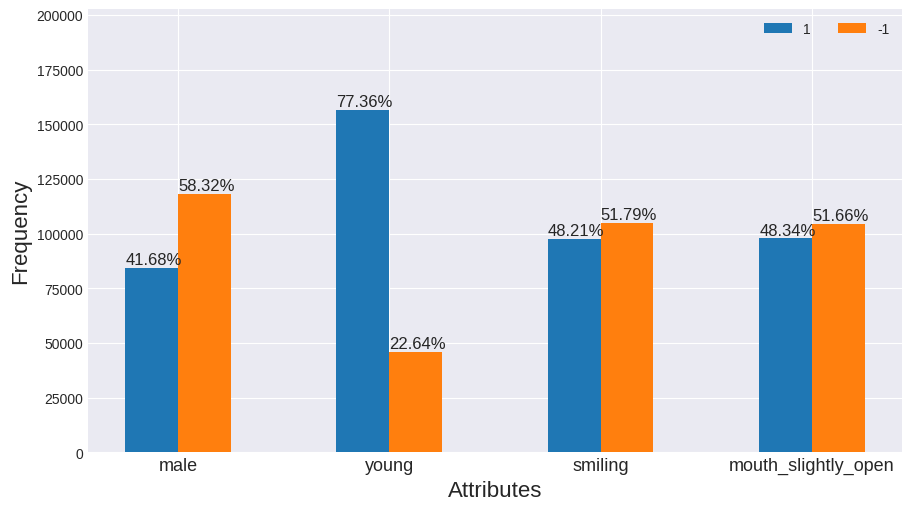

In [22]:
attributes = ("male", "young", "smiling", "mouth_slightly_open")

negative_occurences = []
positive_occurences = []
for a in attributes:
    labels = df_celeba_info[a].value_counts().keys().tolist()
    values = df_celeba_info[a].value_counts().tolist()

    if str(labels[0]) == '-1':
      negative_occurences.append(values[0])
      positive_occurences.append(values[1])
    else:
      negative_occurences.append(values[1])
      positive_occurences.append(values[0])

values = {
    '1': positive_occurences,
    '-1': negative_occurences,
}


x = np.arange(len(attributes))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize = (9,5), layout='constrained')

for attribute, frequency in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, frequency, width, label=attribute)
    for bar in rects:
      yval = bar.get_height()
      perc = f'{(yval /  len(df_celeba_info)) * 100:.2f}%'
      plt.text(bar.get_x() + 0.001 , yval + 1500, perc,  fontsize = 12)

    #ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency', fontsize = 16)
ax.set_xlabel('Attributes',  fontsize = 16)
#ax.set_title(f'Distribution of the annotations', fontsize= 16)

ax.set_xticks(x + width/2, attributes,  fontsize = 13)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, len(df_celeba_info))

plt.show()

Light direction Analysis

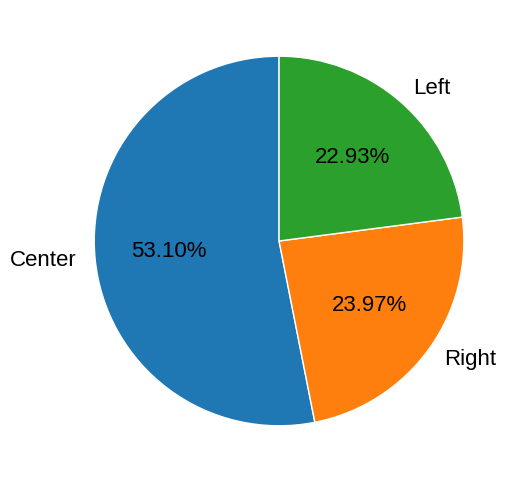

In [23]:

target_labels = df_celeba_light['light_direction'].value_counts().keys().tolist()
target_values = [df_celeba_light['light_direction'].value_counts()[key] for key in target_labels]

fig = plt.figure(figsize=(6, 6))
plt.pie(target_values, labels=[s.title() for s in target_labels], autopct='%1.2f%%', startangle=90, wedgeprops={'width': 1, 'edgecolor': 'white'}, textprops={'fontsize': 16, 'color': 'Black'})

plt.show()

orientations distribution

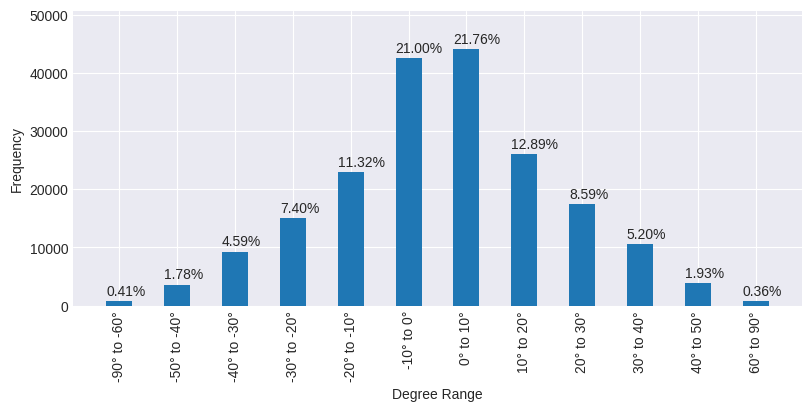

In [24]:
custom_bucket_array = np.linspace(-90, 90, 19)
df_celeba_orientations_bucket = df_celeba_orientations.copy()
df_celeba_orientations_bucket['yaw_bucket'] = pd.cut(df_celeba_orientations['yaw'], custom_bucket_array)

target_labels = sorted(df_celeba_orientations_bucket['yaw_bucket'].value_counts().keys().tolist())
target_values = [ df_celeba_orientations_bucket['yaw_bucket'].value_counts()[key] for key in target_labels]

merged1 = pd.Interval(-90.0, -60.0, closed='right')
intervals = [merged1] +  target_labels[4:]

merged2 =  pd.Interval(60.0, 90.0, closed='right')
target_labels = intervals[:-4] + [merged2]

sum_first_three = sum(target_values[:4])
sum_last_three = sum(target_values[-4:])

target_values = [sum_first_three] + target_values[4:-4] + [sum_last_three]


xticks = np.array(range(0,len(target_labels)))
bar_width = 0.45
fig, ax = plt.subplots(figsize = (8,4), layout='constrained')

bars  = ax.bar(xticks, target_values, width = bar_width)
plt.xlabel('Degree Range')
plt.ylabel('Frequency')


plt.xticks(xticks,labels = [f'{l.left:.0f}° to {l.right:.0f}°' for l in target_labels], rotation = 90, fontsize = 10)

for bar in bars:
    yval = bar.get_height()
    perc = f'{(yval /  len(df_celeba_info)) * 100:.2f}%'
    plt.text(bar.get_x(), yval + 1000, perc,  fontsize = 10)

ax.set_ylim(0, len(df_celeba_info)/4)
plt.show()

### Load celebA-Aligned dataset

In [25]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## Download celeba aligned full dataset##

!wget -q --show-progress --save-cookies cookies.txt 'https://drive.google.com/u/6/uc?id=1oD2ru3blVkQPfMRwhTOhc1YI5KeFvbuD' -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
!wget -q --show-progress --load-cookies cookies.txt -O 'img_align_celeba.zip' \
     'https://drive.google.com/u/6/uc?id=1oD2ru3blVkQPfMRwhTOhc1YI5KeFvbuD&confirm='$(<confirm.txt)

!unzip img_align_celeba.zip


Output streaming troncato alle ultime 5000 righe.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ext

Function that allows to load images from celeba aligned in colab memory

In [26]:
def load_images(image_ids):
    if len(image_ids) == 0:
      return []

    #file_names = df_celeba_info[df_celeba_info['id'].isin(image_ids)]['file_name'].to_numpy()
    # Filter the df_celeba_info dataframe based on image_ids and sort by the order of image_ids
    filtered_df = df_celeba_info[df_celeba_info['id'].isin(image_ids)]
    sorted_df = filtered_df.set_index('id').loc[image_ids].reset_index()

    file_names = sorted_df['file_name'].to_numpy()

    images = []

    for filename in file_names:
      img = cv2.imread(os.path.join('img_align_celeba',filename))
      if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[45:173, 25:153]

        if FACE_SIZE[0] < img.shape[0]:
         img = cv2.resize(img, FACE_SIZE, interpolation = cv2.INTER_AREA)
        else:
         img = cv2.resize(img, FACE_SIZE, interpolation = cv2.INTER_CUBIC)

        images.append(img)
      else:
        print(f'{filename} not founded')

    images = np.asarray(images)
    return images.astype('float32') / 255

Plot Random 4 samples 


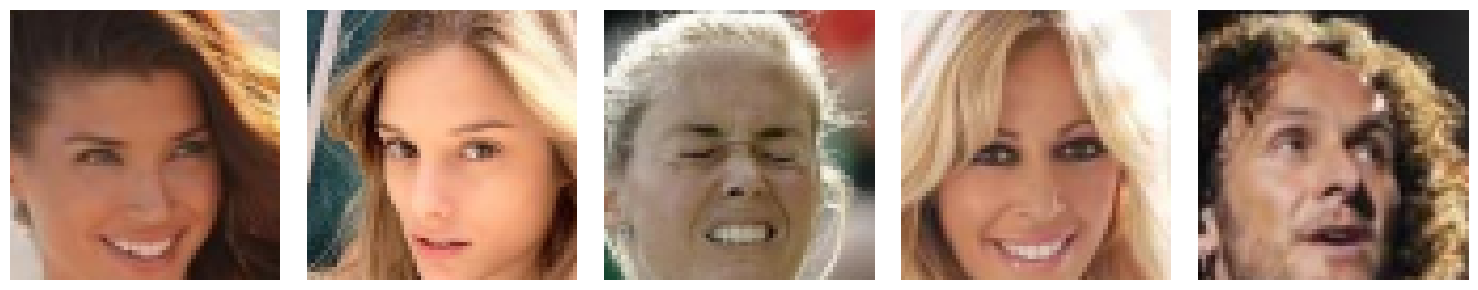

In [27]:
#batch = load_images([26, 29, 39, 114])
#batch = load_images([22629, 24822, 59728, 143376, 57448,71022])
batch = load_images([11030, 20138, 104643, 151832, 119157]) #11030, 20138, 104643, 151832, 119157

print(f"Plot Random 4 samples ")
plot_images_row(batch)

In [28]:
l = [887, 930, 9428, 11030, 11189, 13790, 20138, 57448, 83713, 84626, 86387, 92011, 99164, 99536, 102225, 104643, 105950, 113133, 117052, 138605, 142965, 144378, 144924, 145107, 150659, 151832, 151941, 152390, 119157, 102541]
l.sort()
print(l)

[887, 930, 9428, 11030, 11189, 13790, 20138, 57448, 83713, 84626, 86387, 92011, 99164, 99536, 102225, 102541, 104643, 105950, 113133, 117052, 119157, 138605, 142965, 144378, 144924, 145107, 150659, 151832, 151941, 152390]


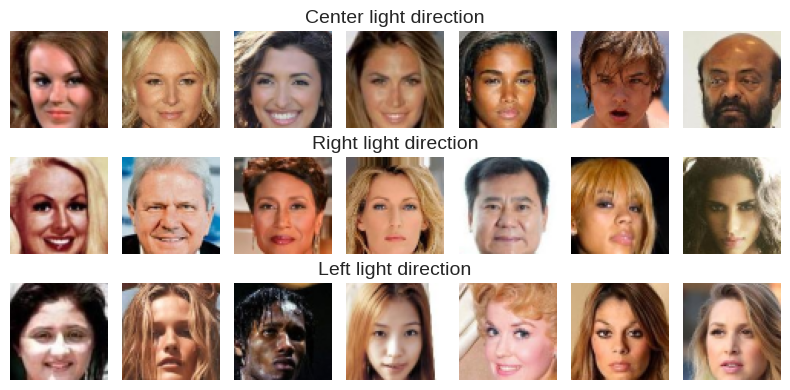

In [29]:
num_images = 7

center_df = df_celeba_info[df_celeba_info['light_direction'] == 'CENTER'].sample(n=num_images)['id'].to_numpy()
center_img = load_images(center_df)

right_df = df_celeba_info[df_celeba_info['light_direction'] == 'RIGHT'].sample(n=num_images)['id'].to_numpy()
right_img = load_images(right_df)

left_df = df_celeba_info[df_celeba_info['light_direction'] == 'LEFT'].sample(n=num_images)['id'].to_numpy()
left_img = load_images(left_df)



fig, axs = plt.subplots(3, num_images, figsize=(8, 4))

for i in range(num_images):
    axs[0, i].imshow(center_img[i])
    axs[0, i].axis('off')
    axs[0, 3].set_title('Center light direction', fontsize=14)

    axs[1, i].imshow(right_img[i])
    axs[1, i].axis('off')
    axs[1, 3].set_title('Right light direction', fontsize=14)

    axs[2, i].imshow(left_img[i])
    axs[2, i].axis('off')
    axs[2, 3].set_title('Left light direction', fontsize=14)


plt.tight_layout()
plt.show()

## Post-processing and pre-processing pipeline


### Post-processing functions

In [30]:
# Clone CodeFormer and enter the CodeFormer folder
%cd /content
!rm -rf CodeFormer
!git clone https://github.com/sczhou/CodeFormer.git
%cd CodeFormer

# Set up the environment
# Install python dependencies
!pip install -r requirements.txt
# Install basicsr
!python basicsr/setup.py develop

# Download the pre-trained model
!python scripts/download_pretrained_models.py facelib
!python scripts/download_pretrained_models.py CodeFormer

%cd ..

!mkdir codeformer_working_dir
!gdown 1UYd_YToBgXqBmhg5p-WRfDZpqc9gKoY- -O codeformer_working_dir/sample.jpg

/content
Cloning into 'CodeFormer'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 594 (delta 176), reused 167 (delta 147), pack-reused 349
Receiving objects: 100% (594/594), 17.31 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (287/287), done.
/content/CodeFormer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
 

In [31]:
def remove_face_background(image, alpha_matting = False):
  image = cast_image_to_float32(image)

  mask =  segmentation_model.predict(np.asarray([image]))[0]
  mask = cast_image_to_int(mask)

  _, mask = cv2.threshold(mask,128,255,cv2.THRESH_BINARY)

  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
  result = np.zeros_like(image)
  result[:, :, :] = (116/255, 107/255, 101/255)
  foreground = cv2.bitwise_and(image, image, mask=mask)
  background = cv2.bitwise_and(result, result, mask=cv2.bitwise_not(mask))
  result = cv2.add(foreground, background)


  result = cast_image_to_float32(result)
  return result

def color_correction(source, target):
    target_size = target.shape[:2]

    source = cast_image_to_int(source)
    target = cast_image_to_int(target)


    lab_in = cv2.cvtColor(target, cv2.COLOR_RGB2LAB)
    lab_ref = cv2.cvtColor(source, cv2.COLOR_RGB2LAB)

    mean_in = np.mean(lab_in, axis=(0, 1), keepdims=True)
    mean_ref = np.mean(lab_ref, axis=(0, 1), keepdims=True)
    std_in = np.std(lab_in, axis=(0, 1), keepdims=True)
    std_ref = np.std(lab_ref, axis=(0, 1), keepdims=True)
    img_arr_out = (lab_in - mean_in) / std_in * std_ref + mean_ref
    img_arr_out[img_arr_out < 0] = 0
    img_arr_out[img_arr_out > 255] = 255

    img_arr_out = cv2.cvtColor(img_arr_out.astype("uint8"), cv2.COLOR_LAB2RGB)

    img_arr_out = cast_image_to_float32(img_arr_out)

    return img_arr_out


def postprocess_face_image_my_model(img, use_color_correction = False, color_correction_source = None):
  img = cast_image_to_float32(img)
  sr_img = superres_model.predict(np.array([img]))[0]
  sr_img = cast_image_to_int(sr_img)
  sr_img = cv2.bilateralFilter(sr_img, 4, sigmaColor = 50, sigmaSpace = 50)
  sr_img = skimage.filters.unsharp_mask(sr_img, radius = 1, amount= 1.0)
  sr_img = sr_img.astype('float32')


  if use_color_correction:
    sr_img = color_correction(color_correction_source, sr_img)

  sr_img = cast_image_to_float32(sr_img)

  return sr_img

def post_process_codeformer(image,  use_color_correction = False,  color_correction_source=None ):
  if not os.path.exists('/content/codeformer_working_dir'):
      os.makedirs('/content/codeformer_working_dir')

  image = cast_image_to_int(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  img_save_path = f'/content/codeformer_working_dir/workimg.png'
  cv2.imwrite(img_save_path, image)

  os.system(f"python /content/CodeFormer/inference_codeformer.py -w 0.75 --has_aligned --input_path /content/codeformer_working_dir --face_upsample --bg_upsampler realesrgan")

  image = cv2.imread(f'/content/results/codeformer_working_dir_0.75/restored_faces/workimg.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)

  if use_color_correction:
    image = color_correction(color_correction_source, image)

  image = cast_image_to_float32(image)

  return image

Call to test the codeformer

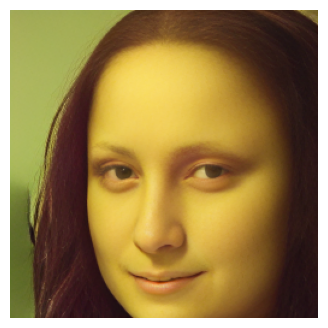

In [32]:
image = cv2.imread('/content/codeformer_working_dir/sample.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

super_res = post_process_codeformer(image)

plot_image(super_res)

## Filter and compute mean images for different orientation in CelebA

In [33]:
def flip_image(images):
    return np.array([np.flip(image, axis=1) for image in images])


def filter_info_dataframe(orientations, attributes,yaw_offset, pitch_offset, roll_offset, relax_attributes, use_only_yaw = False):
  fixed_attributes = ['light_direction', 'male']
  relax_rate = 0.25

  orientation_df = df_celeba_info.copy()

  orientation_df = orientation_df[(orientation_df['yaw'] >=  (orientations['yaw'] - yaw_offset)) & (orientation_df['yaw'] <= (orientations['yaw'] + yaw_offset))]
  if use_only_yaw is False:
    orientation_df = orientation_df[(orientation_df['pitch'] >= (orientations['pitch'] - pitch_offset)) & (orientation_df['pitch'] <= (orientations['pitch'] + pitch_offset))]
    orientation_df = orientation_df[(orientation_df['roll'] >=  (orientations['roll'] - roll_offset)) & (orientation_df['roll'] <= (orientations['roll'] + roll_offset))]

  df_filtered = orientation_df.copy()

  for attr in attributes.keys():
    df_filtered = df_filtered[df_filtered[attr] == attributes[attr]]

  if relax_attributes:
    image_to_add = int(len(df_filtered) * relax_rate)

    filtered_image_ids =  df_filtered['id'].to_numpy()
    orientation_image_ids = orientation_df['id'].to_numpy()
    allowed_image_ids = np.setdiff1d(orientation_image_ids, filtered_image_ids)

    df_relaxed = orientation_df.copy()
    df_relaxed=df_relaxed[df_relaxed['id'].isin(allowed_image_ids)]

    for attr in fixed_attributes:
      if attr in attributes.keys():
        df_relaxed = df_relaxed[df_relaxed[attr] == attributes[attr]]


    df_relaxed = df_relaxed[:min(len(df_relaxed), image_to_add)]

    df_filtered = pd.concat([df_filtered, df_relaxed])

  return df_filtered['id'].to_numpy()


def filter_images(orientations, attributes, num_images_range, max_augmentation_attempt, verbose= False, use_only_yaw = False):

  yaw_starting_offset = 2
  pitch_starting_offset = 2
  roll_starting_offset = 2

  image_nums = []
  image_nums_to_flip = []
  attempt_count = 0
  relax_attributes = False

  attributes_flipped = attributes.copy()

  if 'light_direction' in attributes.keys():
    light_direction_flipped = 'CENTER'

    if attributes['light_direction'] == 'LEFT':
      light_direction_flipped = 'RIGHT'

    elif attributes['light_direction'] == 'RIGHT':
      light_direction_flipped = 'LEFT'

    attributes_flipped['light_direction'] = light_direction_flipped

  flip_orientations = {'yaw': - orientations['yaw'], 'pitch': orientations['pitch'],  'roll':  orientations['roll'] }

  while (len(image_nums) + len(image_nums_to_flip) < num_images_range[0]) and (attempt_count < max_augmentation_attempt):
      image_nums = filter_info_dataframe(orientations,
                                         attributes,
                                         yaw_starting_offset,
                                         pitch_starting_offset,
                                         roll_starting_offset,
                                         relax_attributes = relax_attributes,
                                         use_only_yaw = use_only_yaw)

      image_nums_to_flip = filter_info_dataframe(flip_orientations,
                                                 attributes_flipped,
                                                 yaw_starting_offset,
                                                 pitch_starting_offset,
                                                 roll_starting_offset,
                                                 relax_attributes = relax_attributes,
                                                 use_only_yaw = use_only_yaw)

      attempt_count += 1
      yaw_starting_offset += 2
      pitch_starting_offset += 2
      roll_starting_offset *= 2
      relax_attributes = True

  if len(image_nums) > num_images_range[1]:
    image_nums = np.random.choice(image_nums, size=num_images_range[1], replace=False)

  images = load_images(image_nums)

  if len(image_nums_to_flip) > 0:
    images_to_flip = load_images(image_nums_to_flip)
    if len(images) > 0:
      images =  np.concatenate((images, flip_image(images_to_flip)), axis=0)
    else:
      images = flip_image(images_to_flip)


  if verbose:
    print(f"Total number of attempt: {attempt_count}")
    print(f"Max offset used: yaw +- {yaw_starting_offset}, pitch +- {pitch_starting_offset}, yaw +- {roll_starting_offset}")
    print(f"Number of founded images: {len(images)}")
    print(f'------------------------------------')


  return images

### Load or Precompute all slopes

Code to load all the slopes

In [34]:
!gdown https://drive.google.com/uc?id=1X5EfNPMxJv4s5Pqxn7Vc_FsRAhFc2QOL&export=download #left slopes
!gdown https://drive.google.com/uc?id=1Dk-d5iI3uUrrEUxE3mLcziVPQs2SRyGX&export=download #right slopes


all_slopes_left_npz = np.load('all_slopes_left.npz')
all_slopes_left = dict(zip((k for k in all_slopes_left_npz), (all_slopes_left_npz[k] for k in all_slopes_left_npz)))

all_slopes_right_npz = np.load('all_slopes_right.npz')
all_slopes_right = dict(zip((k for k in all_slopes_right_npz), (all_slopes_right_npz[k] for k in all_slopes_right_npz)))

Downloading...
From: https://drive.google.com/uc?id=1X5EfNPMxJv4s5Pqxn7Vc_FsRAhFc2QOL
To: /content/all_slopes_left.npz
100% 2.37M/2.37M [00:00<00:00, 219MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Dk-d5iI3uUrrEUxE3mLcziVPQs2SRyGX
To: /content/all_slopes_right.npz
100% 2.37M/2.37M [00:00<00:00, 152MB/s]


Code to precompute all the slopes:


```
def compute_all_slopes(orientations_range,
                       attributes,
                       num_images_range = (500 , 1000),
                       max_augmentation_attempt = 5,
                       verbose= True):


  #orientations = list(range(0, 40, 5)) # list(range(-35, 40, 5))
  batch_size = 64
  print(f'All orientattion -> {orientations_range}')
  print(f'Attributes list: {attributes}')

  mean_faces = []
  mean_latents = []

  for yaw in orientations_range:

    orientations = {'yaw': yaw, 'roll': 0, 'pitch': 0}
    print(f'Yaw used -> {yaw}')

    images = filter_images(orientations = orientations,
                            attributes = attributes,
                            num_images_range = num_images_range,
                            max_augmentation_attempt = max_augmentation_attempt,
                            verbose = verbose,
                            use_only_yaw = True)

    if len(images) > num_images_range[1]:
      images = images[:num_images_range[1]]
      print(f'Capped length to : {len(images)}')

    mean_faces.append(np.mean(images, axis=0))

    num_images = images.shape[0]
    num_batches = int(np.ceil(num_images / batch_size))
    image_batches = np.array_split(images, num_batches)

    embeddings_original = []
    for batch in image_batches:
        embeddings = embedding_model(batch).numpy()
        embeddings_original.append(embeddings)

    embeddings_original = np.concatenate(embeddings_original, axis=0)
    mean_latents.append((np.mean(embeddings_original, axis=0)))


  X =  np.asarray(list(range(0, len(mean_latents)))).reshape(-1, 1)
  print(f' X: {X}')
  y = np.asarray([ matrix_to_point(A) for A in mean_latents])
  # Get the slope the regression line
  regressor = LinearRegression(fit_intercept=True).fit(X, y )
  slope = point_to_matrix(regressor.coef_.flatten())

  return slope

import itertools

light_direction_values = ['CENTER', 'RIGHT', 'LEFT']
other_values = [-1, 1]

attributes_subset =  ['light_direction', 'male', 'young', 'smiling']
all_values = [light_direction_values if attr == 'light_direction' else other_values for attr in attributes_subset]

map_dict = {}

all_slopes_left = {}
all_slopes_right = {}

for i, combination in enumerate(itertools.product(*all_values)):
    result_dict = {attr: value for attr, value in zip(attributes_subset, combination)}
    print(f'Subset attributes -> {result_dict}')
    map_dict[combination] = i
    print(result_dict)

    slope_left = compute_all_slopes(list(range(0, 41, 8)), result_dict)
    all_slopes_left.update({str(result_dict) : slope_left})

    slope_right = compute_all_slopes(sorted(list(range(-40, 1, 8)), reverse = True), result_dict)
    all_slopes_right.update({str(result_dict) : slope_right})


outfile = 'all_slopes_left.npz'
np.savez(outfile, **all_slopes_left)

outfile = 'all_slopes_right.npz'
np.savez(outfile, **all_slopes_right)

```



### Compute the average embedding of the mean images

utility function to analyze the principal component of the latent space

In [35]:
def root_points_PCA_analysis(input_img_embedding,
                             latent_samples,
                             direction,
                             root_images,
                             regressor,
                             regressor_sampling_points,
                             annotations):

  root_images_data =  np.asarray([ matrix_to_point(m) for m in root_images])
  latent_samples_data =  np.asarray([ matrix_to_point(m) for m in latent_samples])
  input_img_embedding_data = np.asarray([matrix_to_point(input_img_embedding)])
  root_points_regressor_line_data = regressor.predict(np.linspace(0, len(root_images), 100).reshape(-1, 1))

  input_point_x = 0
  m = point_to_matrix(regressor.coef_.flatten())
  sampling_points_regressor_line_data = []
  for x_coord in (np.linspace(0, regressor_sampling_points[-1], 100)):
      sampling_points_regressor_line_data.append(m * (x_coord - input_point_x) + input_img_embedding)

  sampling_points_regressor_line_data = np.asarray([matrix_to_point(p) for p in sampling_points_regressor_line_data])

  data_to_fit =  np.concatenate((root_images_data, latent_samples_data, input_img_embedding_data, root_points_regressor_line_data, sampling_points_regressor_line_data))
  pca= PCA(n_components=2)
  pca = pca.fit(data_to_fit)

  reduced_root_images = pca.transform(root_images_data)
  reduced_latent_samples = pca.transform(latent_samples_data)

  reduced_input_embedding = pca.transform(input_img_embedding_data)
  reduced_root_points_regressor_line = pca.transform(root_points_regressor_line_data)
  reduced_sampling_points_regressor_line = pca.transform(sampling_points_regressor_line_data)

  fig = plt.figure(figsize = (8, 5))
  ax = fig.add_subplot(111)

  ax.plot(reduced_root_points_regressor_line[:, 0], reduced_root_points_regressor_line[:, 1], c='g', label='Root Points Linear Regression Line',  zorder=1)
  ax.plot(reduced_sampling_points_regressor_line[:, 0], reduced_sampling_points_regressor_line[:, 1], c='c', label='Samplig Points Linear Regression Line',  zorder=1)

  ax.scatter(reduced_input_embedding[:, 0], reduced_input_embedding[:, 1], c='r', marker='o', label = 'Input image embedding',  zorder=2)
  ax.scatter(reduced_latent_samples[:, 0], reduced_latent_samples[:, 1], c='m', marker='o', label = 'Latent samples',  zorder=2)
  ax.scatter(reduced_root_images[:, 0], reduced_root_images[:, 1], c='b', marker='o', label = 'Roots Points',  zorder=2)

  for i in range(len(reduced_root_images)):
    ax.annotate(annotations[i], (reduced_root_images[:, 0][i] + 2, reduced_root_images[:, 1][i]), color='b')


  ax.set_xlabel('First component')
  ax.set_ylabel('Second component')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3) #ax.legend(loc='upper right', bbox_to_anchor=(1.65, 1.))
  plt.title(f'PCA for latent space analysis - {direction} direction')
  plt.grid()

  plt.xlim(np.min(np.concatenate((reduced_input_embedding[:, 0], reduced_latent_samples[:, 0], reduced_root_images[:, 0])) ) *1.5,
           np.max(np.concatenate((reduced_input_embedding[:, 0], reduced_latent_samples[:, 0], reduced_root_images[:, 0]))) * 1.5 )
  plt.show()

  return

Create root images using the average embedding for each rotation

In [36]:
def compute_single_root_point(orientations,
                              attributes,
                              num_images_range,
                              max_augmentation_attempt = 5,
                              verbose= True,
                              use_only_yaw = False,
                              use_centroid = True):

  batch_size = 64

  images = filter_images(orientations = orientations,
                         attributes = attributes,
                         num_images_range = num_images_range,
                         max_augmentation_attempt = max_augmentation_attempt,
                         verbose = verbose,
                         use_only_yaw = use_only_yaw)

  if len(images) > num_images_range[1]:
    images = images[:num_images_range[1]]
    if verbose:
      print(f'Capped length to : {len(images)}')

  mean_image =  np.mean(images, axis=0)

  num_batches = int(np.ceil(images.shape[0] / batch_size))
  image_batches = np.array_split(images, num_batches)

  embeddings = [embedding_model(batch).numpy() for batch in image_batches]
  embeddings = np.concatenate(embeddings, axis=0)

  if use_centroid:
    embeddings =  np.mean(embeddings, axis=0)

  return mean_image, embeddings


In [37]:
def create_root_images(starting_orientations,
                       attributes,
                       yaw_correction = 5,
                       num_root_images = 5,
                       num_images_range = (500, 1000) ,
                       use_only_yaw = False,
                       use_centroid = True,
                       verbose = False):
  mean_faces = []
  root_images = []

  orientations = starting_orientations.copy()
  root_images_yaws = []

  for i in range(num_root_images):
    mean_image, root_point = compute_single_root_point(orientations,
                                                        attributes,
                                                        num_images_range = num_images_range,
                                                        use_only_yaw = use_only_yaw,
                                                        use_centroid =  use_centroid,
                                                        verbose = verbose)

    mean_faces.append(mean_image)
    root_images.append(root_point)
    if use_centroid:
      root_images_yaws.append(orientations["yaw"])
    else:
      root_images_yaws.append([orientations["yaw"] for im in root_point])

    orientations['yaw'] =  orientations['yaw'] + yaw_correction

  if use_centroid is False:
    root_images = np.concatenate(root_images, axis=0)
    root_images_yaws = np.concatenate(root_images_yaws, axis=0)

  if verbose:
    plot_images_row(mean_faces,
                    subplot_titles= [f'Yaw = {a:.2f}°' for a in root_images_yaws],
                    plot_title = 'Mean faces for orientation used as base for root images')

    if use_centroid:
      plot_images_row((np.clip(root_images, -2.5, 2.5) + 2.5) / 5.,
                      subplot_titles= [f'Yaw = {a:.2f}°' for a in root_images_yaws],
                      plot_title = 'renorm seed Average embedding for each mean face used as root images')
    else:
      print(f'Plotting root points is not possible due to the disabled use of centroids')

  return np.asarray(root_images), root_images_yaws

## Sampling with linearRegressor

Define a utility function for mapping a matrix to a point, and vice versa.

In [38]:
def matrix_to_point(A):
    # Convert a matrix to a point by flattening it
    return A.reshape(-1)

def point_to_matrix(p):
    # Convert a point to a matrix by reshaping it
    return p.reshape(64, 64, 3)

def generate_from_latent(latent):
  generated = diffusion_model.reverse_diffusion(np.expand_dims(latent, axis = 0), 10)
  generated = diffusion_model.denormalize(generated)
  return generated[0].numpy()

The following code computes the new face orientations required to automate the rotation process

In [39]:
model_3D_points = np.array([(0.0, 0.0, 0.0),  # Nose tip
                            (0.0, -330.0, -65.0),  # Chin
                            (-225.0, 170.0, -135.0),  # Left eye left corner
                            (225.0, 170.0, -135.0),  # Right eye right corner
                            (-150.0, -150.0, -125.0),  # Left Mouth corner
                            (150.0, -150.0, -125.0)])  # Right mouth corner

dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

def get_face_orientation(image):
    landmarks = face_recognition.face_landmarks(cast_image_to_int(image.copy()), None, model='large')
    if landmarks is None or len(landmarks) == 0:
      print(f'Unable to compute face landmarks for face orientation')
      return None
    landmarks = landmarks[0]

    reduced_landmarks = np.array([landmarks['nose_bridge'][3],
                                  landmarks['chin'][8],
                                  landmarks['left_eye'][0],
                                  landmarks['right_eye'][3],
                                  landmarks['top_lip'][0],
                                  landmarks['top_lip'][6]], dtype='double')

    focal_length = image.shape[1]
    center = (image.shape[1] // 2, image.shape[0] // 2)
    camera_matrix = np.array([[focal_length, 0, center[0]],
                              [0, focal_length, center[1]],
                              [0, 0, 1]], dtype="double")

    success, rotation_vector, translation_vector = cv2.solvePnP(model_3D_points, reduced_landmarks, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    if success:
        rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
        proj_matrix = np.hstack((rvec_matrix, translation_vector))

        eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
        pitch, yaw, roll = [math.radians(x) for x in eulerAngles]

        pitch = math.degrees(math.asin(math.sin(pitch)))
        roll = -math.degrees(math.asin(math.sin(roll)))
        yaw = math.degrees(math.asin(math.sin(yaw)))

        return {'yaw': yaw, 'pitch': pitch, 'roll': roll}

    return None


Create a function that performs linear regression on a specified number of root images, which correspond to the average embeddig of different yaw corrections. This function should also enable the sampling of points using the input image's embedding to improve the correction results.

In [40]:
def face_frontalization(img, starting_orientations, attributes_subset, num_root_points = 5, yaw_threshold = 3, max_attempt = 3, use_only_yaw = True, verbose = True):

  if starting_orientations['yaw'] > 0:
    yaw_correction = - abs(0 - starting_orientations['yaw']) / (num_root_points - 1)
  else:
    yaw_correction = + abs(0 - starting_orientations['yaw']) / (num_root_points - 1)

  root_images, root_images_yaws = create_root_images(starting_orientations,
                                                     attributes_subset,
                                                     yaw_correction = yaw_correction,
                                                     num_root_images = num_root_points,
                                                     use_only_yaw = use_only_yaw,
                                                     verbose = verbose)


  X = np.asarray(list(range(0, len(root_images)))).reshape(-1, 1)
  y = np.asarray([ matrix_to_point(A) for A in root_images])


  regressor = LinearRegression(fit_intercept=True).fit(X, y )
  slope = point_to_matrix(regressor.coef_.flatten())

  input_point_x = 0 #abs(starting_orientations['yaw'])
  input_img_embedding = embedding_model(tf.expand_dims(img, 0))[0].numpy()


  alpha = 0
  count = 0
  while count < max_attempt:
    count += 1
    print(f'-------------------------------------------------------------------------------')
    print(f'Face frontalization attempt num: {count}, with alpha: {alpha}')

    latent_samples = [(slope * (x_coord - input_point_x + alpha) + input_img_embedding) for x_coord in X]
    latent_samples = np.asarray(latent_samples)

    generated_samples = [generate_from_latent(l) for l in  latent_samples]
    plot_images_row(generated_samples, plot_title = f'Generated samples - face frontalization')

    output_img = generated_samples[-1]
    output_img = post_process_codeformer(output_img,
                                        use_color_correction = True,
                                        color_correction_source=img)

    plot_image(output_img)
    computed_orientations = get_face_orientation(output_img)
    output_img = cv2.resize(output_img, FACE_SIZE, interpolation = cv2.INTER_AREA)

    if computed_orientations is not None:
      print(f'\n Computed orientations for the last sample: {computed_orientations}')
      if abs(computed_orientations['yaw']) < yaw_threshold:
        break

    alpha += 1.

  starting_orientations['yaw'] = computed_orientations['yaw']
  return output_img, starting_orientations


In [41]:
def sample_from_linear_regression(img,
                                  orientations,
                                  attributes,
                                  direction,
                                  direction_sampling_yaw_threshold,
                                  yaw_degree_step,
                                  num_root_points,
                                  sampled_image_num = 3,
                                  max_attempt = 3,
                                  use_only_yaw = True,
                                  use_precomputed_slope = False,
                                  verbose = False):


    if use_precomputed_slope == False:
      print(f'Computing the slope for {direction} sampling')
      root_images, root_images_yaws = create_root_images(orientations,
                                                  attributes,
                                                  yaw_correction = yaw_degree_step,
                                                  num_root_images = num_root_points,
                                                  use_only_yaw = use_only_yaw,
                                                  verbose = verbose)

      X = np.asarray(list(range(0, len(root_images)))).reshape(-1, 1)
      y = np.asarray([ matrix_to_point(A) for A in root_images])

      regressor = LinearRegression(fit_intercept=True).fit(X, y )
      slope = point_to_matrix( regressor.coef_.flatten())

    else:
      print(f'Recovering precomputed slope for {direction} sampling')
      X = np.asarray(list(range(0, 6))).reshape(-1, 1)

      if direction == 'Left':
        slope = all_slopes_left[str(attributes)]
      else:
        slope = all_slopes_right[str(attributes)]

    input_point_x = 0
    input_img_embedding = embedding_model(tf.expand_dims(img, 0))[0].numpy()

    alpha = 0
    count = 0

    x_sampling_points = X[-sampled_image_num:] if len(X) >= sampled_image_num else X

    while count < max_attempt:
      count += 1
      print(f'-------------------------------------------------------------------------------')
      print(f'{direction} sampling -  attempt num: {count}, with alpha: {alpha}')

      latent_samples = [(slope * (x_coord - input_point_x + alpha) + input_img_embedding) for x_coord in x_sampling_points]
      latent_samples = np.asarray(latent_samples)

      generated_samples = [generate_from_latent(l) for l in  latent_samples]
      plot_images_row(generated_samples, plot_title = f'Generated samples - direction: {direction}')

      last_sample = post_process_codeformer(generated_samples[-1],
                                            use_color_correction = True,
                                            color_correction_source=img)

      orientations_last_sample = get_face_orientation(last_sample)

      if orientations_last_sample is not None:
        print(f'\n Computed orientations for the last sample: {orientations_last_sample}')
        if round(abs(orientations_last_sample['yaw'])) >= direction_sampling_yaw_threshold:
          break

      alpha += 1.


      if verbose and use_precomputed_slope == False:
        root_points_PCA_analysis(direction  = direction,
                                input_img_embedding= input_img_embedding,
                                latent_samples = latent_samples,
                                root_images = root_images,
                                regressor = regressor,
                                regressor_sampling_points = X + alpha,
                                annotations = [f'Yaw = {a:.2f}°' for a in root_images_yaws])

    return generated_samples, slope

In [42]:
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # example list
n = 5  # number of equispaced items to get

result = np.linspace(0, len(X)-1, n, dtype=int)  # get indices of equispaced items
equispaced_items = [X[i] for i in result]  # get the equispaced items from the list

print(equispaced_items)  # output: [1, 3, 5, 7, 10]

[1, 3, 5, 7, 10]


In [43]:
def remove_background_from_input_image(img):
  img = post_process_codeformer(img, use_color_correction = False, color_correction_source=None)
  img = remove_face_background(img)
  return cv2.resize(img, FACE_SIZE, interpolation = cv2.INTER_AREA)

def get_rounded_yaw(img_yaw):
  orientations = list(range(-45, 50, 5))
  closest_index = min(range(len(orientations)), key=lambda i: abs(orientations[i] - img_yaw))
  return orientations[closest_index]

def linear_regression_rotation(image_id,
                               attributes_subset = [],

                               start_frontalization_yaw_threshold = 10,
                               frontalization_num_root_points = 5,
                               frontalization_accepted_yaw_threshold = 3,
                               frontalization_max_attempt = 3,
                               frontalization_use_only_yaw = True,

                               direction_sampling_yaw_threshold = 25,
                               direction_sampling_yaw_degree_step = 8,
                               direction_sampling_num_root_points = 5,
                               direction_sampling_image_num = 3,
                               direction_sampling_max_attempt = 3,
                               direction_sampling_use_only_yaw = True,
                               direction_sampling_use_precomputed_slope = False,

                               remove_bg = True,
                               verbose = True):


  input_img = load_images([image_id])[0]
  if remove_bg:
    print(f'--- Preprocessing ---')
    print('Removing background from input image')
    input_img = remove_background_from_input_image(input_img)

  print(f'\nInput image id: {image_id}')
  plot_image(input_img)

  orientations = df_celeba_info[df_celeba_info['id'] == image_id][['yaw', 'pitch', 'roll']].to_dict('records')[0]
  if any(np.isnan(val) for val in orientations.values()):
    print("Can not find orientations for this image")
    return None, None, None

  #orientations['yaw'] = get_rounded_yaw(orientations['yaw'])
  attributes = df_celeba_info[df_celeba_info['id'] == image_id][attributes_subset].to_dict('records')[0]
  print(f'Starting orientations of image {image_id} -> {orientations}')
  print(f'Selected attributes subset values of image {image_id} -> {attributes}')

  focus_img = input_img.copy()
  if abs(orientations['yaw']) > start_frontalization_yaw_threshold:
    print(f'\n--- Applying face frontalization to enhance the results ---')
    focus_img, orientations = face_frontalization(focus_img,
                                                  orientations,
                                                  attributes,
                                                  num_root_points = frontalization_num_root_points,
                                                  yaw_threshold = frontalization_accepted_yaw_threshold,
                                                  max_attempt = frontalization_max_attempt,
                                                  use_only_yaw = frontalization_use_only_yaw,
                                                  verbose = verbose)
    print(f'Image after face frontalization')
    plot_image(focus_img)


  print(f'\n--- Left direction Linear regression sampling ---')
  generated_samples_left, slope_left =  sample_from_linear_regression(img = focus_img,
                                                                       orientations = orientations,
                                                                       attributes = attributes,
                                                                       direction = 'Left',
                                                                       direction_sampling_yaw_threshold = direction_sampling_yaw_threshold,
                                                                       yaw_degree_step = direction_sampling_yaw_degree_step,
                                                                       num_root_points = direction_sampling_num_root_points,
                                                                       sampled_image_num = direction_sampling_image_num,
                                                                       max_attempt = direction_sampling_max_attempt,
                                                                       use_only_yaw = direction_sampling_use_only_yaw,
                                                                       use_precomputed_slope = direction_sampling_use_precomputed_slope,
                                                                       verbose = verbose)


  print(f'\n--- Computing root points for Right LinearRegressor ---')
  generated_samples_right, slope_right = sample_from_linear_regression(img = focus_img,
                                                                        orientations = orientations,
                                                                        attributes = attributes,
                                                                        direction = 'Right',
                                                                        direction_sampling_yaw_threshold = direction_sampling_yaw_threshold,
                                                                        yaw_degree_step = - direction_sampling_yaw_degree_step,
                                                                        num_root_points = direction_sampling_num_root_points,
                                                                        sampled_image_num = direction_sampling_image_num,
                                                                        max_attempt = direction_sampling_max_attempt,
                                                                        use_only_yaw = direction_sampling_use_only_yaw,
                                                                        use_precomputed_slope = direction_sampling_use_precomputed_slope,
                                                                        verbose = verbose)

  merged_results = np.concatenate([generated_samples_left[::-1], [focus_img], generated_samples_right ], axis = 0)

  return merged_results, slope_left, slope_right

In [44]:
def postprocess_results(results, color_correction_source, remove_bg = False, model = 'codeformer'):
  if remove_bg:
    print('Removing background from color correction source')
    color_correction_source = post_process_codeformer(color_correction_source, use_color_correction = False, color_correction_source=None)
    color_correction_source = remove_face_background(color_correction_source)
    #color_correction_source = cv2.resize(color_correction_source, FACE_SIZE, interpolation = cv2.INTER_AREA)

  generated_sample_postprocessed = []
  if model == 'our':
      generated_sample_postprocessed = [postprocess_face_image_my_model(img, use_color_correction = True, color_correction_source=color_correction_source) for img in results]
  elif model == 'codeformer':
      generated_sample_postprocessed = [post_process_codeformer(img, use_color_correction = True, color_correction_source=color_correction_source) for img in results]

  return generated_sample_postprocessed

### Rotate a specified image

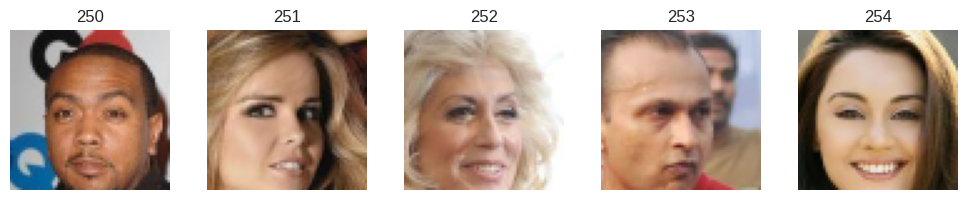

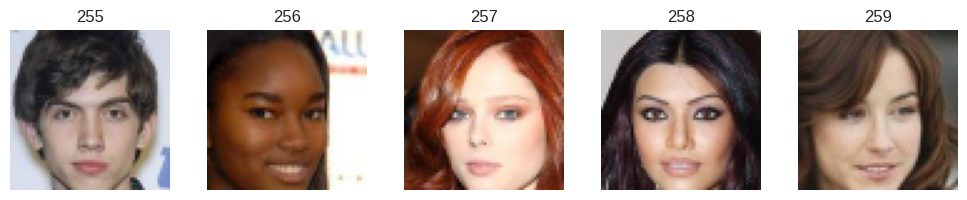

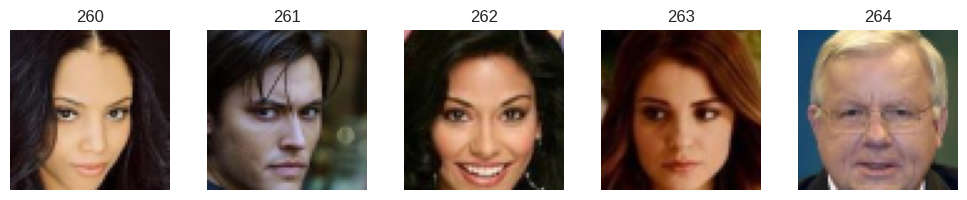

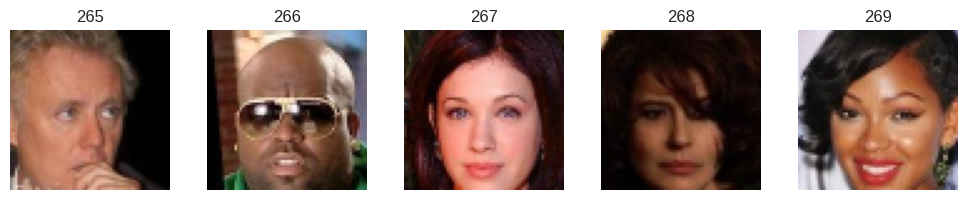

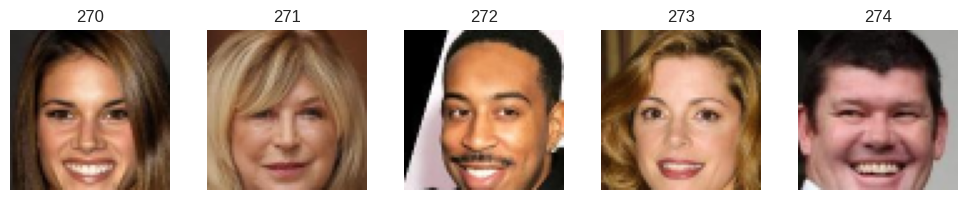

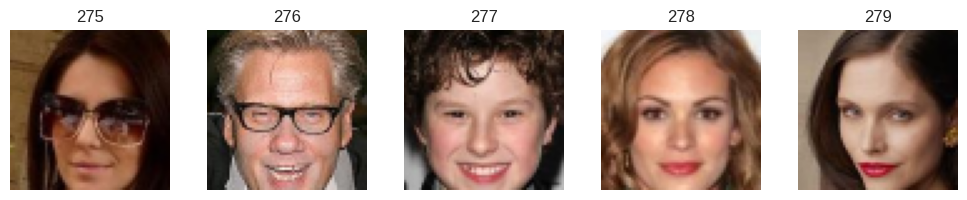

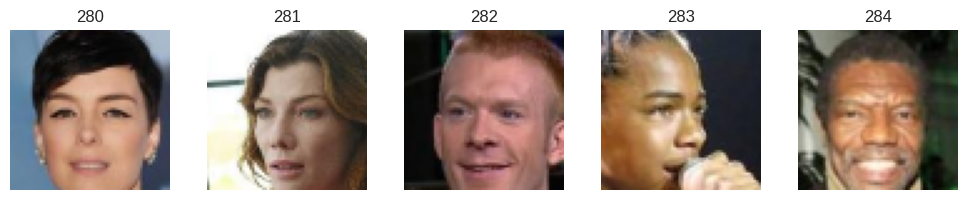

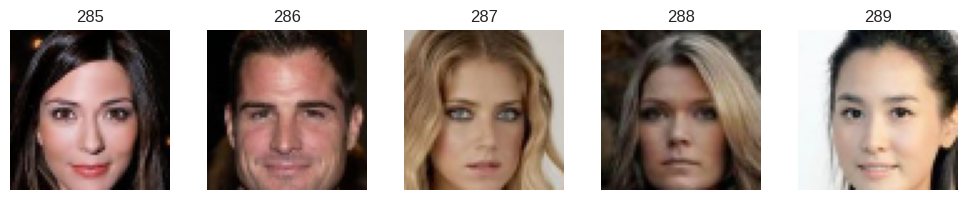

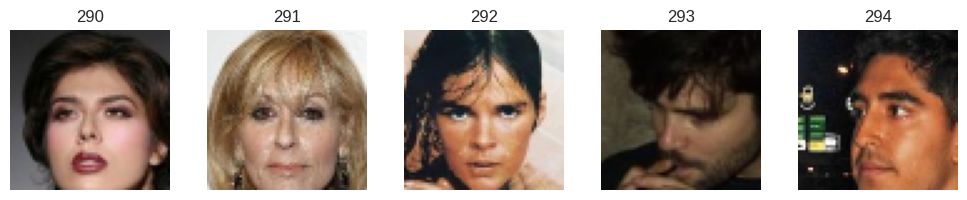

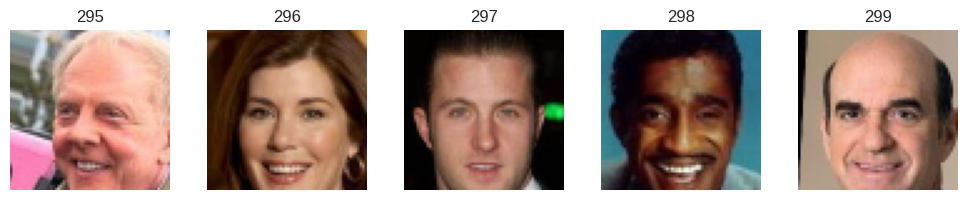

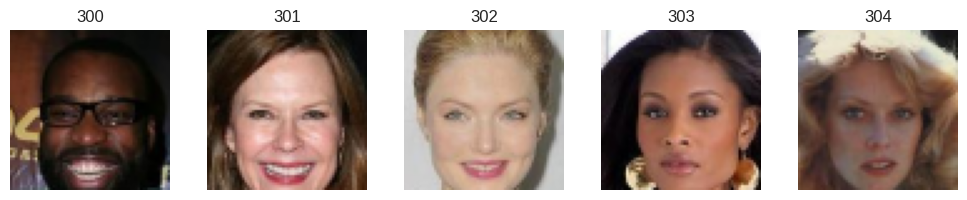

In [45]:
n = 250
m = 300

ids_list = [list(range(i, i+5)) for i in range(n, m+1, 5)]

for ids in ids_list:
  plot_images_row(load_images(ids), subplot_titles=ids,single_fig_size=2)

In [46]:
def compute_slope_similarity(A, B):
  distance = np.sqrt(np.sum(np.square(A - B)))
  similarity = np.dot(A.flatten(), B.flatten()) / (norm(A.flatten()) * norm(B.flatten()))
  return distance, similarity

--- Preprocessing ---
Removing background from input image
1/1 [==============================] - 10s 10s/step

Input image id: 120122


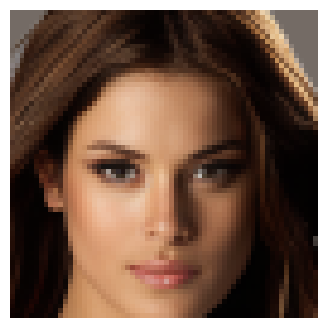

Starting orientations of image 120122 -> {'yaw': -6.518310730077963, 'pitch': 0.089416121647853, 'roll': -2.34754466550129}
Selected attributes subset values of image 120122 -> {'light_direction': 'LEFT', 'male': -1, 'young': 1, 'smiling': -1}

--- Left direction Linear regression sampling ---
Computing the slope for Left sampling
Total number of attempt: 2
Max offset used: yaw +- 6, pitch +- 6, yaw +- 8
Number of founded images: 1096
------------------------------------
Capped length to : 1000
Total number of attempt: 2
Max offset used: yaw +- 6, pitch +- 6, yaw +- 8
Number of founded images: 1428
------------------------------------
Capped length to : 1000
Total number of attempt: 2
Max offset used: yaw +- 6, pitch +- 6, yaw +- 8
Number of founded images: 829
------------------------------------
Total number of attempt: 2
Max offset used: yaw +- 6, pitch +- 6, yaw +- 8
Number of founded images: 623
------------------------------------
Total number of attempt: 2
Max offset used: yaw +

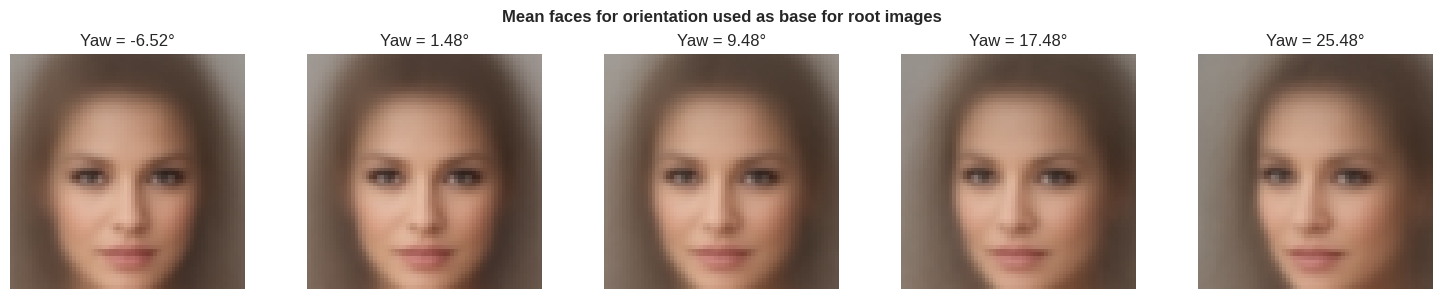

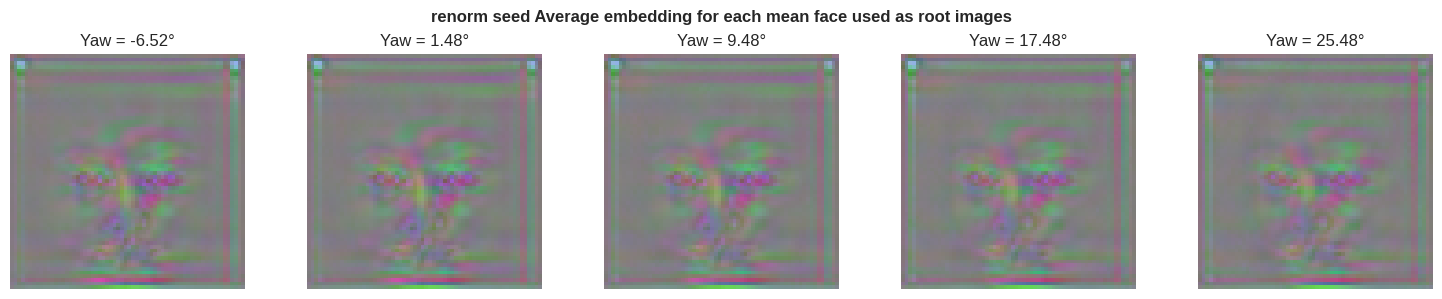

-------------------------------------------------------------------------------
Left sampling -  attempt num: 1, with alpha: 0


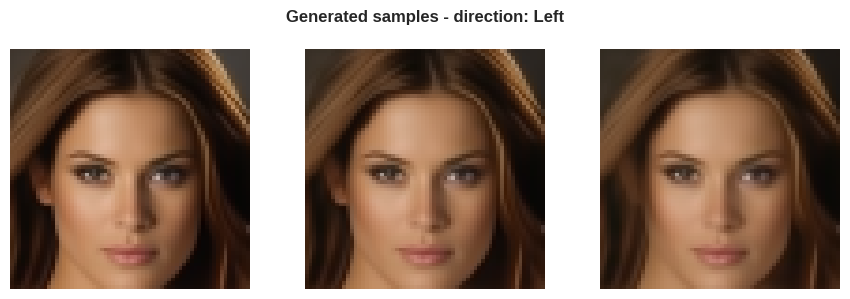


 Computed orientations for the last sample: {'yaw': 1.2596621776022774, 'pitch': -1.2664636612521403, 'roll': -0.5293428578941921}


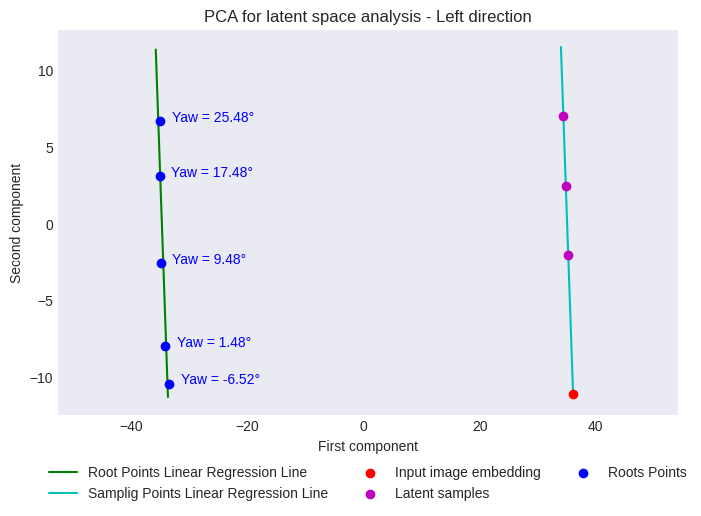

-------------------------------------------------------------------------------
Left sampling -  attempt num: 2, with alpha: 1.0


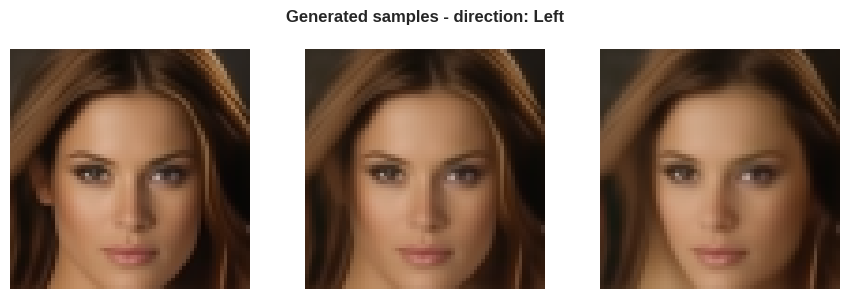


 Computed orientations for the last sample: {'yaw': 15.325955013996026, 'pitch': -1.240468532602913, 'roll': 1.160413028448116}


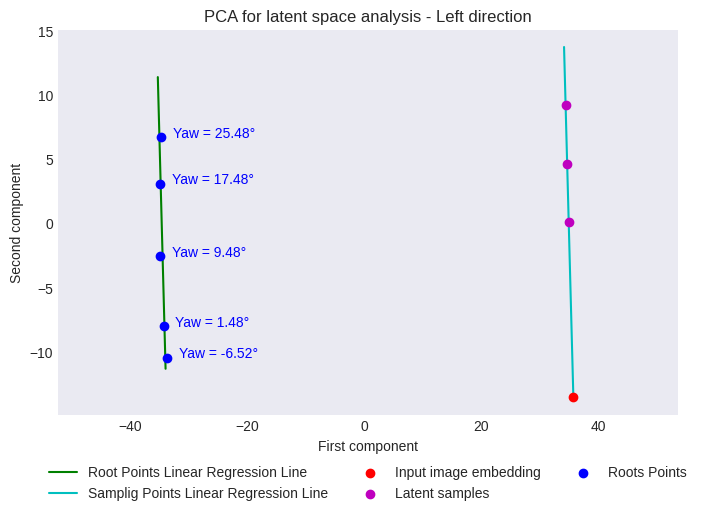

-------------------------------------------------------------------------------
Left sampling -  attempt num: 3, with alpha: 2.0


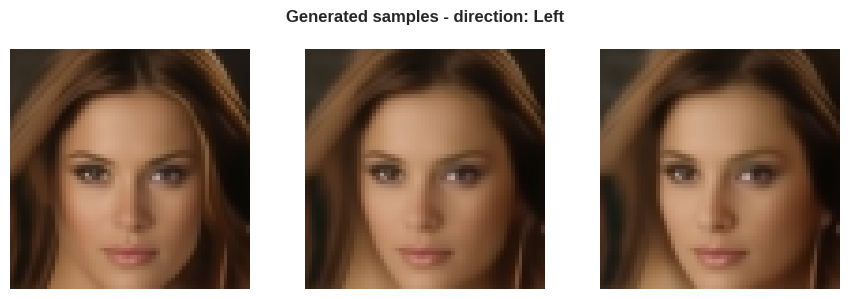


 Computed orientations for the last sample: {'yaw': 21.28871807636994, 'pitch': -1.7186966683889973, 'roll': 1.623697915894261}


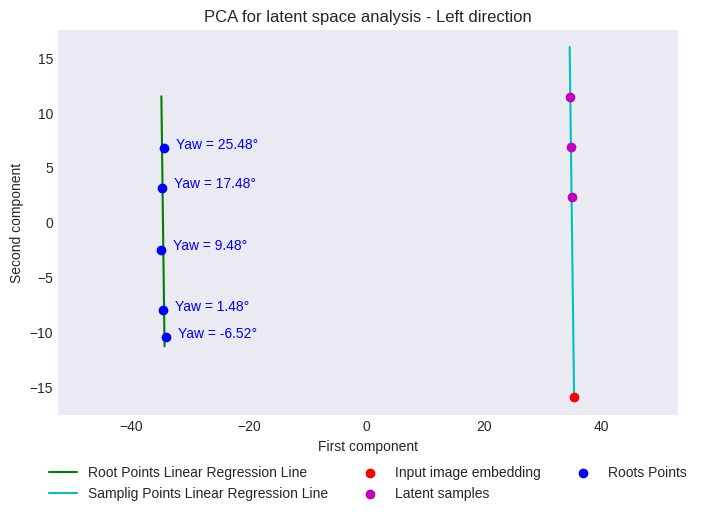

-------------------------------------------------------------------------------
Left sampling -  attempt num: 4, with alpha: 3.0


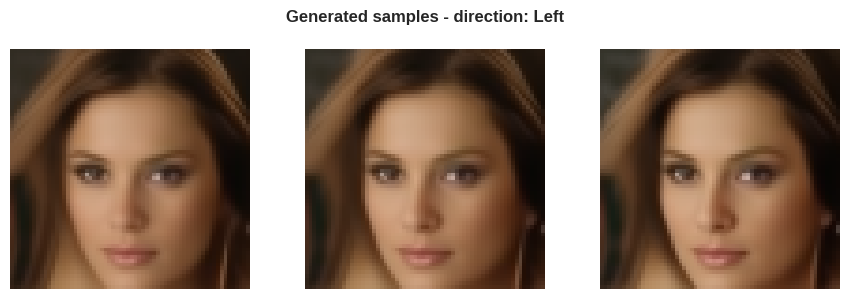


 Computed orientations for the last sample: {'yaw': 23.223217437038493, 'pitch': -2.5534969672533263, 'roll': 1.2856320314347693}


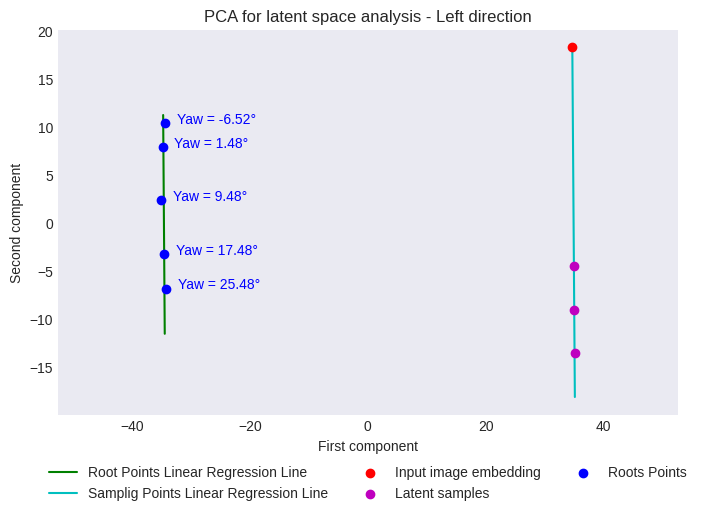


--- Computing root points for Right LinearRegressor ---
Computing the slope for Right sampling
Total number of attempt: 2
Max offset used: yaw +- 6, pitch +- 6, yaw +- 8
Number of founded images: 1096
------------------------------------
Capped length to : 1000
Total number of attempt: 2
Max offset used: yaw +- 6, pitch +- 6, yaw +- 8
Number of founded images: 619
------------------------------------
Total number of attempt: 3
Max offset used: yaw +- 8, pitch +- 8, yaw +- 16
Number of founded images: 1699
------------------------------------
Capped length to : 1000
Total number of attempt: 3
Max offset used: yaw +- 8, pitch +- 8, yaw +- 16
Number of founded images: 1485
------------------------------------
Capped length to : 1000
Total number of attempt: 3
Max offset used: yaw +- 8, pitch +- 8, yaw +- 16
Number of founded images: 924
------------------------------------


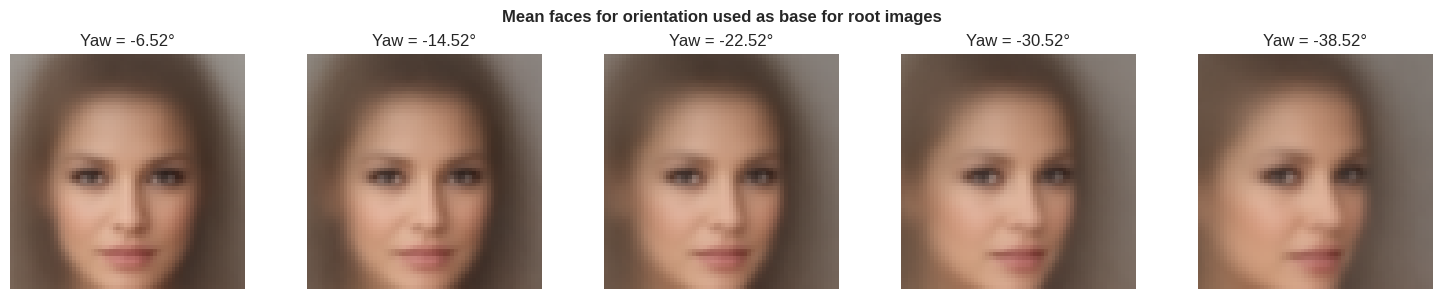

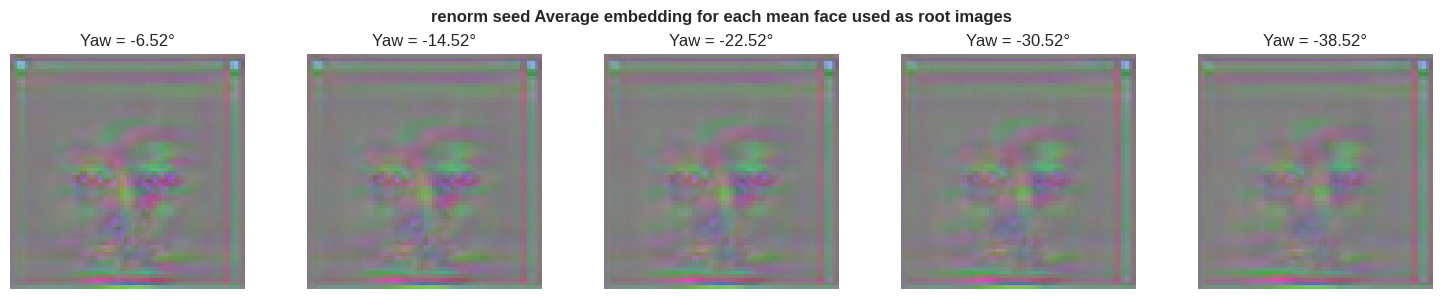

-------------------------------------------------------------------------------
Right sampling -  attempt num: 1, with alpha: 0


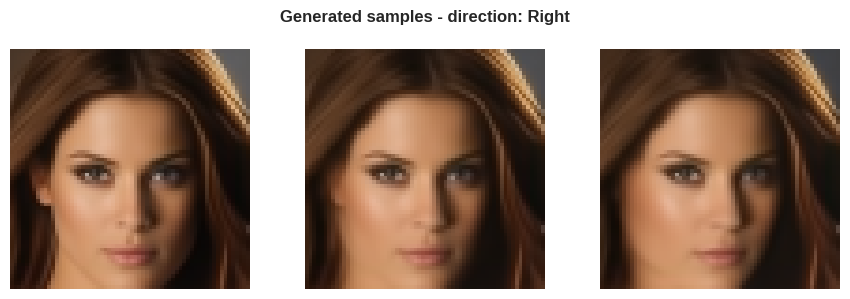


 Computed orientations for the last sample: {'yaw': -23.69120248377586, 'pitch': -3.942598483978298, 'roll': -2.2895178624328425}


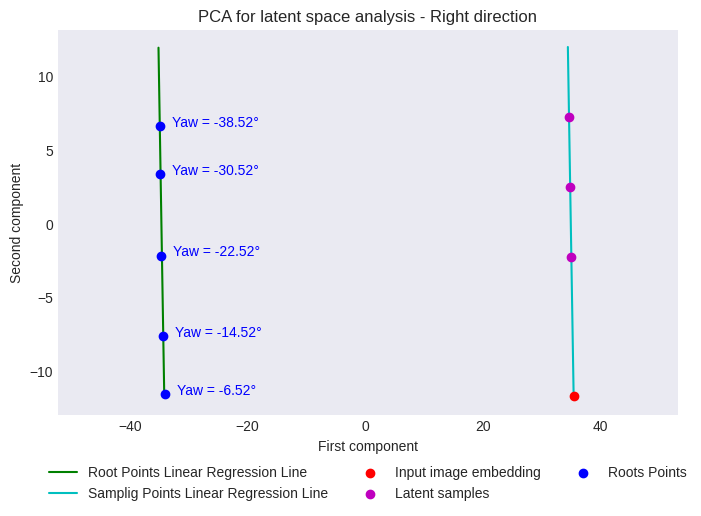

-------------------------------------------------------------------------------
Right sampling -  attempt num: 2, with alpha: 1.0


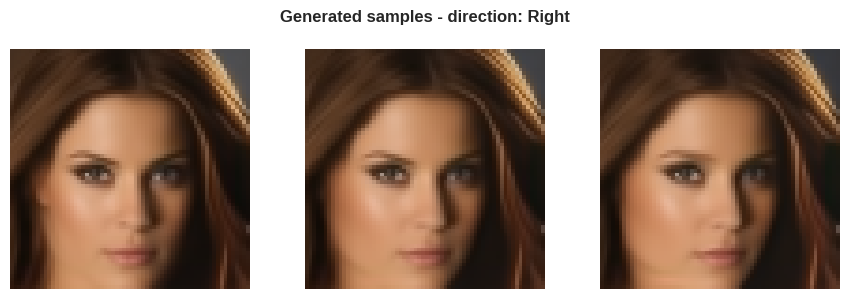


 Computed orientations for the last sample: {'yaw': -26.148180989529397, 'pitch': -3.9751506868448767, 'roll': -2.390824149774901}
Similarity between slope_first and slope_second for image 120122
Euclidean distance: 5.678221072788989
Cosine similarity: 0.2560982885610949


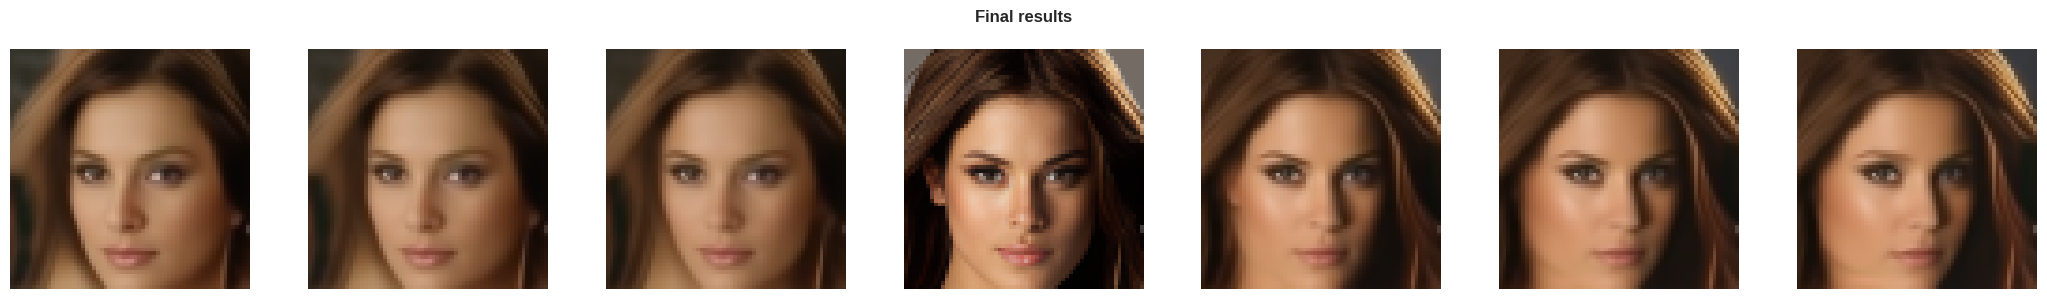

In [47]:
needed_attributes = ['light_direction','male','young','smiling']
#needed_attributes = ['light_direction']
#needed_attributes = ['young']

image_id = 120122

results, slope_first, slope_second = linear_regression_rotation(image_id,
                                                                attributes_subset = needed_attributes,

                                                                start_frontalization_yaw_threshold = 12,
                                                                frontalization_num_root_points = 5,
                                                                frontalization_accepted_yaw_threshold = 3,
                                                                frontalization_max_attempt = 3,
                                                                frontalization_use_only_yaw = True,

                                                                direction_sampling_yaw_threshold = 25, #15,
                                                                direction_sampling_yaw_degree_step = 8, #8
                                                                direction_sampling_num_root_points = 5,
                                                                direction_sampling_image_num = 3,
                                                                direction_sampling_max_attempt = 4,
                                                                direction_sampling_use_only_yaw = False,
                                                                direction_sampling_use_precomputed_slope = False,

                                                                remove_bg = True,
                                                                verbose = True)

print(f'Similarity between slope_first and slope_second for image {image_id}')
distance, similarity = compute_slope_similarity(slope_first, slope_second)
print(f'Euclidean distance: {distance}')
print(f'Cosine similarity: {similarity}')

plot_images_row(results, plot_title='Final results')

## Post-processing Results and Creating GIF

Removing background from color correction source
1/1 [==============================] - 0s 34ms/step


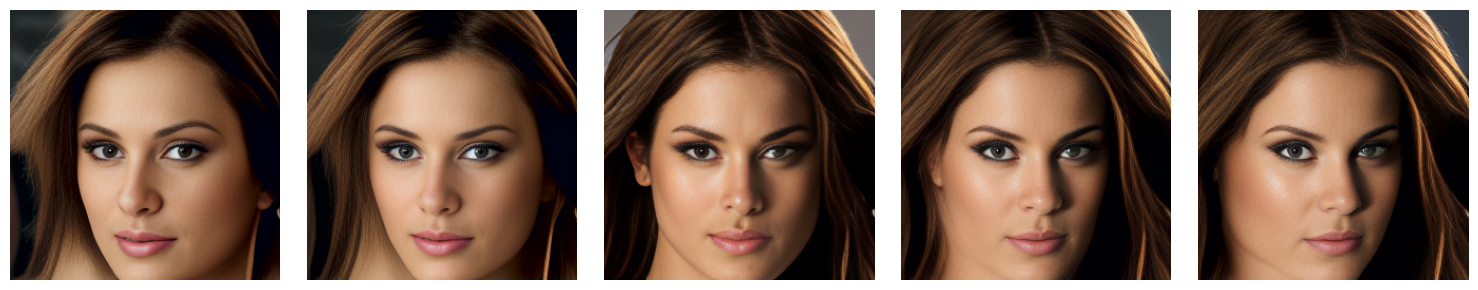

In [48]:
results = results[[0,2,3,4,5]]
#print(results.shape)
post_processed_results = postprocess_results(results, color_correction_source = load_images([image_id])[0], remove_bg = True, model = 'codeformer')
#post_processed_results = postprocess_results(results, color_correction_source = load_images([image_id])[0], remove_bg = True, model = 'our')
plot_images_row(post_processed_results) #, plot_title='Final results')

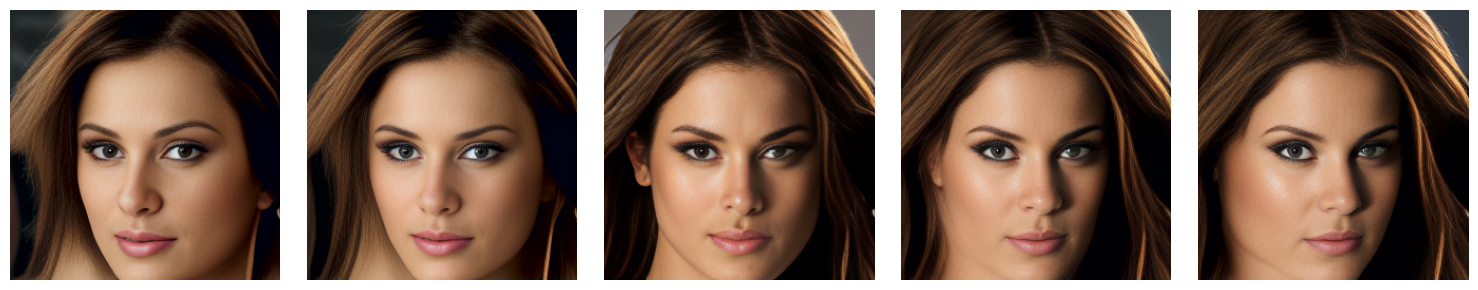

In [49]:
plot_images_row(post_processed_results)

Sampling intermediate frames into the latent space to enhance the smoothness of the GIF

In [50]:

def sample_new_frames(base_frames, sample_linspace = [0, 10], frame_num = 15, model = 'codeformer'):
  base_frames = np.asarray([cv2.resize(img, FACE_SIZE, interpolation = cv2.INTER_AREA) for img in base_frames])

  base_frames_embedding = embedding_model(base_frames).numpy()

  y = np.asarray([ matrix_to_point(A) for A in base_frames_embedding])

  X = np.arange(0, len(base_frames_embedding))
  X = X.reshape(-1, 1)

  regressor = LinearRegression(fit_intercept=True).fit(X, y )

  x_new = np.linspace(0, len(base_frames) - 1, frame_num).reshape(-1, 1)

  y_new = regressor.predict(x_new)
  y_new = np.asarray([point_to_matrix(l) for l in y_new])

  gif_frames = [generate_from_latent(l) for l in  y_new]

  plot_images_row(gif_frames, plot_title = 'gif_frames')
  if model == 'our':
      gif_frames = [postprocess_face_image_my_model(img, use_color_correction = False, color_correction_source=None) for img in gif_frames]
  elif model == 'codeformer':
      gif_frames = [post_process_codeformer(img, use_color_correction = False, color_correction_source=None) for img in gif_frames]

  plot_images_row(gif_frames, plot_title = 'gif_frames')
  return gif_frames


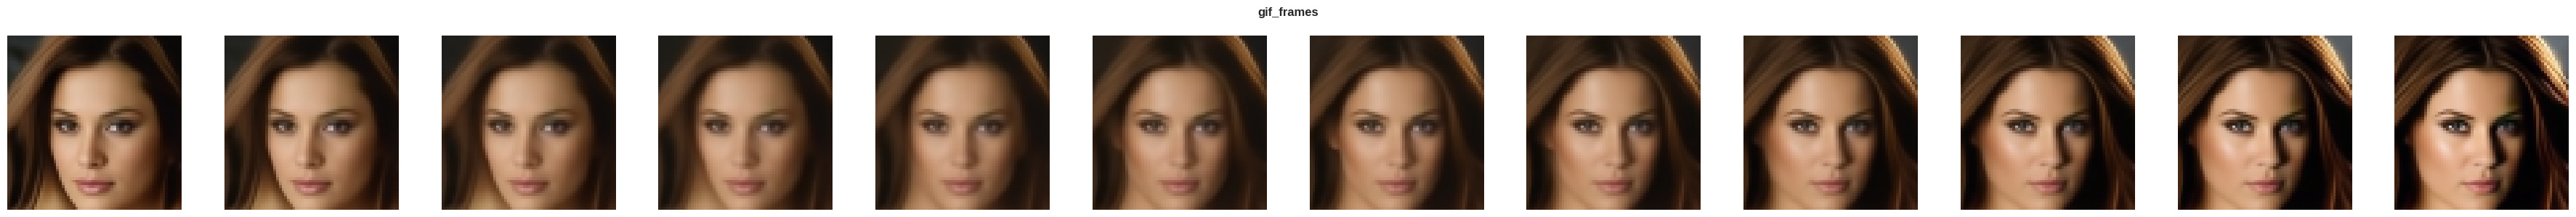

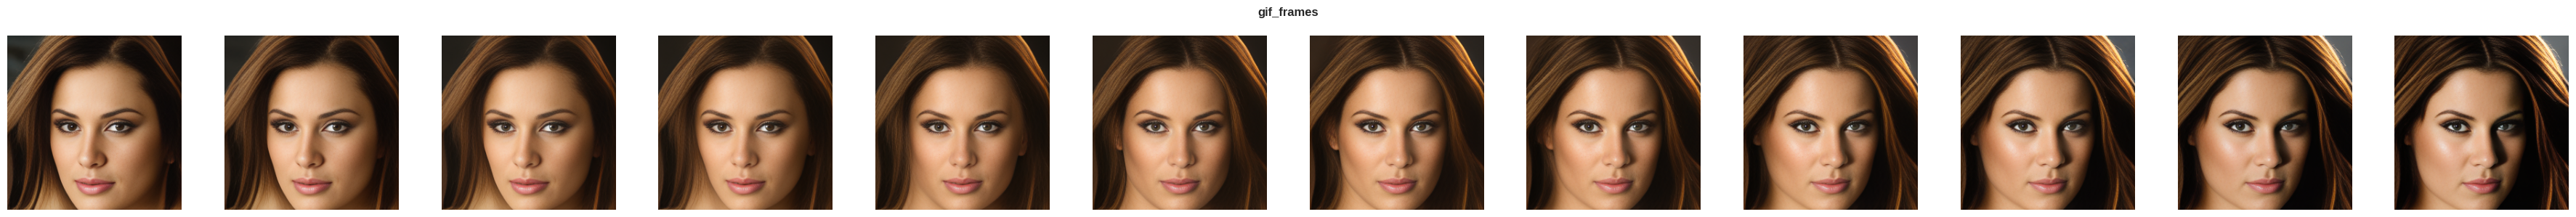

In [51]:
gif_frames = sample_new_frames(post_processed_results, frame_num = 12, model = 'codeformer')
#gif_frames = post_processed_results

Make gif with post processed results

In [52]:
gif_name =  make_gif(image_id = image_id, gif_base_frames = gif_frames, frame_duration = 0.07, interpolated_frame_nums = 14)
Image(open(gif_name, 'rb').read())

## Analysis of Slope computation
In this section, we will analyze the calculation of slope using various image subsets, assess the stability of the proposed method, and evaluate the usefulness of the attributes considered.

Three utility functions have been defined in this section:

- The first utility function is used for computing both the Euclidean distance and cosine similarity between matrices, and will be utilized for the slope analysis.
- The second is used to compute similarity between each pair of slopes.
- The Third utility function is used to create a heatmap that visually displays the differences in slope similarity.

In [53]:
def compute_slope_similarity(A, B):
  distance = np.sqrt(np.sum(np.square(A - B)))
  similarity = np.dot(A.flatten(), B.flatten()) / (norm(A.flatten()) * norm(B.flatten()))
  return distance, similarity

def compute_similarities(all_slopes):
    similarities= np.zeros((len(all_slopes), len(all_slopes)))

    for i in range(0, len(all_slopes)):
        slope1 = all_slopes[i]

        for j in range(i, len(all_slopes)):
            slope2 = all_slopes[j]

            _, similarity = compute_slope_similarity(slope1, slope2)

            similarities[i, j] = similarity
            similarities[j, i] = similarities[i, j]

    return similarities

def make_heatmap(data, labels, title, figsize = (5, 5), image_labels=None, cmap='coolwarm', annot=True, fmt='.2f', vmin=0, vmax=1, image_zoom=0.6, x_align=0.25, y_align=1.75):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(pd.DataFrame(data, index=labels, columns=labels),
                cmap=cmap,
                annot=annot,
                fmt=fmt,
                vmin=vmin,
                vmax=vmax)
    plt.title(title)

    fig = plt.gcf()
    width, height = fig.get_size_inches()
    ax = plt.gca()
    x_tick_labels = ax.xaxis.get_ticklabels()
    y_tick_labels = ax.yaxis.get_ticklabels()

    if image_labels is not None:
      for i, im in enumerate(image_labels):
          ib = OffsetImage(im, zoom=image_zoom)
          ib.image.axes = ax

          # Add image to x-axis tick label
          ab = AnnotationBbox(ib,
                              x_tick_labels[i].get_position(),
                              frameon=False,
                              box_alignment=(0.5, height*y_align)
                              )
          ax.add_artist(ab)

          # Add image to y-axis tick label
          ab = AnnotationBbox(ib,
                              y_tick_labels[i].get_position(),
                              frameon=False,
                              box_alignment=(width*x_align, 0.5)
                              )
          ax.add_artist(ab)

    plt.show()


### Slope Stability analysis

The purpose of this section is to assess the stability of the proposed method for computing the slope. Specifically, we will analyze whether using different subsets of images with identical orientations and attributes yields consistent results in computing the slope. To accomplish this, we will use three distinct subsets of images to calculate the slope and then evaluate the stability by performing a cosine similarity analysis between them.

Before beginning the test, it's necessary to define some utility functions that will be used to compute the root points for each of the subsets being considered.

In [54]:
def compute_multiple_root_points(orientations,
                                  attributes,
                                  num_images_range,
                                  max_augmentation_attempt = 5,
                                  num_group = 3,
                                  verbose= True,
                                  use_only_yaw = False):

  orientations_correction = orientations.copy()
  batch_size = 64

  images = filter_images(orientations = orientations,
                         attributes = attributes,
                         num_images_range = num_images_range,
                         max_augmentation_attempt = max_augmentation_attempt,
                         verbose = verbose,
                         use_only_yaw = use_only_yaw)

  print(f'   total lenght of images founded: {len(images)}')
  #num_img_for_group = int(len(images)/num_group)

  np.random.shuffle(images)
  groups = np.array_split(images, num_group)
  print(f'   Number of groups: {len(groups)}')

  mean_latent_for_group = []
  for count, group in enumerate(groups):
    print(f'   Group num {count+1} shape: {group.shape}')

    num_batches = int(np.ceil(group.shape[0] / batch_size))
    image_batches = np.array_split(group, num_batches)

    embeddings = [embedding_model(batch).numpy() for batch in image_batches]
    embeddings = np.concatenate(embeddings, axis=0)
    mean_latent_for_group.append(np.mean(embeddings, axis=0))

  return mean_latent_for_group

def create_root_images_group(starting_orientations, attributes, yaw_correction = 5, num_root_images = 5, num_images_range = (500, 1000) ,  use_only_yaw = False, num_group = 3, verbose = False):
  mean_faces = []
  root_images_group = []

  orientations = starting_orientations.copy()
  annotations = []

  print(f'Computing {num_group} groups of root points taking random sample')
  print(f'Subset of attributes used: {attributes}')
  print(f'Starting orientations : {starting_orientations}')

  for i in range(num_root_images):
    print(f' - Computing root images num {i+1}, with yaw {orientations["yaw"]}')

    mean_latent_for_group = compute_multiple_root_points(orientations,
                                                         attributes,
                                                         num_images_range = num_images_range,
                                                         use_only_yaw = use_only_yaw,
                                                         num_group = num_group,
                                                         verbose = verbose)


    root_images_group.append(mean_latent_for_group)


    annotations.append(f'Yaw = {orientations["yaw"]:.2f}°')
    orientations['yaw'] =  orientations['yaw'] + yaw_correction


  root_images_group = np.asarray(root_images_group)
  root_images_group = np.transpose(root_images_group, (1, 0, 2, 3, 4))

  for count,group in enumerate(root_images_group):
    plot_images_row((np.clip(group, -2.5, 2.5) + 2.5) / 5.,
                    subplot_titles=annotations,
                    plot_title = f'root images of group {count+1}')

  return root_images_group, annotations

The final utility function is used to compute the slope for each group.

In [55]:
def compute_slope_for_attributes(orientations,
                                 attributes_subset,
                                 use_only_yaw = False,
                                 num_root_points_left = 10,
                                 yaw_correction_left = 5,
                                 num_root_points_right = 10,
                                 yaw_correction_right = 5,
                                 num_images_range = (500, 1000),
                                 num_group = 3
                                 ):


  orientations['yaw'] = get_rounded_yaw(orientations['yaw'])

  slope_left_group = []
  slope_right_group = []

  root_images_left_group, annotations = create_root_images_group(orientations,
                                                attributes_subset,
                                                yaw_correction = yaw_correction_left,
                                                num_root_images = num_root_points_left,
                                                use_only_yaw = use_only_yaw,
                                                num_images_range = num_images_range,
                                                num_group = num_group,
                                                verbose = False)

  root_images_left_group = np.asarray(root_images_left_group)
  print(root_images_left_group.shape)

  for group in root_images_left_group:
    plot_images_row((np.clip(group, -2.5, 2.5) + 2.5) / 5.,
                    subplot_titles=annotations,
                    plot_title = f'root images of group')

    X_left = np.arange(0, len(group)).reshape(-1, 1)
    y_left = np.asarray([ matrix_to_point(A) for A in group])
    regressor_left = LinearRegression(fit_intercept=True).fit(X_left, y_left )
    slope_left = point_to_matrix(regressor_left.coef_.flatten())
    slope_left_group.append(slope_left)


  root_images_right_group, _ = create_root_images_group(orientations,
                                                  attributes_subset,
                                                  yaw_correction = - yaw_correction_right,
                                                  num_root_images = num_root_points_right,
                                                  use_only_yaw = use_only_yaw,
                                                  num_images_range = num_images_range,
                                                  num_group = num_group,
                                                  verbose = False)


  root_images_left_group = np.asarray(root_images_left_group)

  for group in root_images_right_group:
    X_right = np.arange(0, len(group)).reshape(-1, 1)
    y_right = np.asarray([ matrix_to_point(A) for A in group])
    regressor_right = LinearRegression(fit_intercept=True).fit(X_right, y_right )
    slope_right = point_to_matrix(regressor_right.coef_.flatten())
    slope_right_group.append(slope_right)

  return np.asarray(slope_left_group), np.asarray(slope_right_group)

With the utility function now defined, we manually select a specific subset of attributes and a particular orientation (in this case, the central orientation with yaw = 0, pitch = 0, and roll = 0). We proceed to calculate the three left slopes and three right slopes using different subsets of images.

In [ ]:

orientations = {'yaw': 0., 'pitch': 0., 'roll': 0.}

attributes_subset_list = [{'male': -1, 'light_direction': 'CENTER',  'young': 1, 'smiling': 1},
                     {'male': 1, 'light_direction': 'CENTER',  'young': 1, 'smiling': -1},
                     {'male': -1, 'light_direction': 'LEFT',  'young': -1, 'smiling': 1},
                     {'male': 1, 'light_direction': 'RIGHT',  'young': 1, 'smiling': 1}]


for attributes_subset in attributes_subset_list:
  print(f'Attribute subset used for this analysis: {attributes_subset}')

  slope_left_group, slope_right_group = compute_slope_for_attributes(orientations,
                                                        attributes_subset,
                                                        use_only_yaw = True,
                                                        num_images_range = (1000, 1500),
                                                        num_root_points_left = 4,
                                                        yaw_correction_left = 10,
                                                        num_root_points_right = 4,
                                                        yaw_correction_right = 10)

  make_heatmap(data = compute_similarities(slope_left_group),
              labels = ['Subset 1', 'Subset 2', 'Subset 3'],
              title = None,
              image_labels=None, figsize = (5, 4))

  make_heatmap(data = compute_similarities(slope_right_group),
              labels = ['Subset 1', 'Subset 2', 'Subset 3'],
              title = None, #'Cosine similarity for different group - RIGHT SLOPE',
              image_labels=None, figsize = (5, 4))

  print('---------------------------------------\n')

As expected, when using a common subset of attributes as the first one attempted (e.g., {'male': -1, 'light_direction': 'CENTER', 'young': 1, 'smiling': 1}), the computation of the slope is very stable regardless of the subset of images used for its calculation. The cosine similarity never falls below 0.96. However, if a subset of attributes that are more rare in the dataset is used, the process is a bit less stable. For example, in the case of {'male': -1, 'light_direction': 'LEFT', 'young': -1, 'smiling': 1}, both 'young=-1' and 'light_direction=LEFT' significantly reduce the number of images available in the dataset to compute the slope. As a result, the slope computation becomes less stable, and the cosine similarity between different subset of images with the same attributes can drop to about 0.80 in some cases.

### Slope Similarity Analysis among different Images
In this section, we will analyze the similarity of slopes among different images with varying orientations and attributes to determine whether similar images have similar slopes and vice versa.

1/1 [==============================] - 0s 35ms/step
Image: 16399


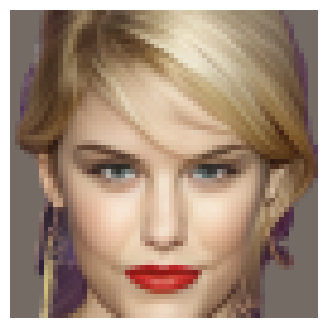

Attributes -> {'male': -1, 'light_direction': 'CENTER', 'young': 1, 'smiling': -1, 'mouth_slightly_open': -1}
Orientations -> {'yaw': -5, 'pitch': 0.6173893700622194, 'roll': -0.9354377853888872}


TypeError: ignored

In [57]:
attributes_subset = ['male',
                     'light_direction',
                     'young',
                     'smiling',
                     'mouth_slightly_open']

ids = [16399, 70126, 99, 18, 114, 129, 164, 221] #222 212

num_root_points_left = 4
yaw_step_left = 10
x_sample_points_left = [1, 2, 3, 4]

num_root_points_right = 4
yaw_step_right = 10
x_sample_points_right = [1, 2, 3, 4]

slopes_left = {}
slopes_right = {}

for id in ids:
  img = load_images([id])[0]
  img = remove_background_from_input_image(img)
  print(f'Image: {id}')
  plot_image(img)

  orientations = df_celeba_info[df_celeba_info['id'] == id][['yaw', 'pitch', 'roll']].to_dict('records')[0]
  orientations['yaw'] = get_rounded_yaw(orientations['yaw'])

  attributes = df_celeba_info[df_celeba_info['id'] == id][attributes_subset].to_dict('records')[0]
  print(f'Attributes -> {attributes}')
  print(f'Orientations -> {orientations}')

  generated_left, slope_left = sample_from_linear_regression(img = img,
                                                            orientations = orientations ,
                                                            attributes = attributes,
                                                            direction = 'left',
                                                            num_root_images = num_root_points_left,
                                                            yaw_correction = yaw_step_left,
                                                            x_sample_points = x_sample_points_left,
                                                            use_only_yaw = True,
                                                            verbose = False)

  generated_right, slope_right = sample_from_linear_regression(img = img,
                                                            orientations = orientations ,
                                                            attributes = attributes,
                                                            direction = 'right',
                                                            num_root_images = num_root_points_right,
                                                            yaw_correction = - yaw_step_right,
                                                            x_sample_points = x_sample_points_right,
                                                            use_only_yaw = True,
                                                            verbose = False)


  print(f'Similarity between slope_left and slope_right for image {id}')
  distance, similarity = compute_slope_similarity(slope_left, slope_right)
  print(f'Euclidean distance: {distance}')
  print(f'Cosine similarity: {similarity}')


  slopes_left.update({id: slope_left})
  slopes_right.update({id: slope_right})
  print(f'--------------------------------\n')

As we can see from the print, the left and right slopes are significantly different from each other. This suggests that the intuition to use two separate linear regressors, one for the left direction and one for the right direction, is correct.

We will compute the Euclidean distance and cosine similarity for every possible pair combination of images.

In [ ]:
similarities_left = np.zeros((len(slopes_left), len(slopes_left)))
similarities_right = np.zeros((len(slopes_right), len(slopes_right)))
labels = []

for i in range(0, len(ids)):
  img1 = load_images([ids[i]])[0]
  labels.append(ids[i])
  slope_left1 = slopes_left[ids[i]]
  slope_right1 = slopes_right[ids[i]]
  for j in range(i, len(ids)):
    img2 = load_images([ids[j]])[0]
    slope_left2 = slopes_left[ids[j]]
    slope_right2 = slopes_right[ids[j]]
    plot_images_row([img1, img2], subplot_titles=[f'img {ids[i]}', f'img {ids[j]}'])

    print(f'Similarity between slope_left:')
    distance_left, similarity_left = compute_slope_similarity(slope_left1, slope_left2)
    print(f'Euclidean distance: {distance_left}')
    print(f'Cosine similarity: {similarity_left}')

    print(f'\n')
    print(f'Similarity between slope_right:')
    distance_right, similarity_right = compute_slope_similarity(slope_right1, slope_right2)
    print(f'Euclidean distance: {distance_right}')
    print(f'Cosine similarity: {similarity_right}')

    similarities_left[i, j] = similarity_left
    similarities_left[j, i] = similarities_left[i, j]

    similarities_right[i, j] = similarity_right
    similarities_right[j, i] = similarities_right[i, j]

    print('---------------------------------\n')


We will create a heatmap of the similarities that were just computed to visually inspect them.

In [ ]:
images =  load_images(labels)
plot_images_row(images, subplot_titles=[f'Image {id}' for id in labels])
print('')
make_heatmap(data = similarities_left,
             labels = labels,
             title = None, #'Cosine similarity - LEFT SLOPE',
             image_labels=images,
             x_align=0.2,
             y_align=1.7,
             figsize = (8, 6))
print('')
make_heatmap(data = similarities_right,
             labels = labels,
             title = None, #'Cosine similarity - RIGHT SLOPE',
             image_labels=images,
             x_align=0.2,
             y_align=1.7,
             figsize = (8, 6))


As expected, similar images have similar slopes. For example, images 16399 and 70126 have a high degree of similarity. On the other hand, image 114, which is the only male image in the list, is dissimilar to all the other images.

Another observation is that even though the women's images have similar attributes and orientations, their different light directions affect the slope, as we will see in the next section. This reduces the cosine similarity between them to some extent.

### Analyzing the Impact of Attribute Removal on Slope Computation

In this section, we will explore the effects of removing one attribute from the full subset of selected attributes, which includes 'male', 'light_direction', 'young', 'smiling', and 'mouth_slightly_open'. The purpose of this analysis is to determine whether any of these attributes can be safely ignored when computing the slope.

In [ ]:
ids = [18, 114, 99]
num_root_points_left = 4
yaw_step_left = 10
x_sample_points_left = [1, 2, 3, 4]

num_root_points_right = 4
yaw_step_right = 10
x_sample_points_right = [1, 2, 3, 4]

for id in ids:

  missing_attr_similarity_left = {}
  missing_attr_similarity_right = {}

  img = load_images([id])[0]
  img = remove_background_from_input_image(img)
  print(f'Image: {id}')
  plot_image(img)

  orientations = df_celeba_info[df_celeba_info['id'] == id][['yaw', 'pitch', 'roll']].to_dict('records')[0]
  orientations['yaw'] = get_rounded_yaw(orientations['yaw'])


  attributes_subset = ['male', 'light_direction', 'young', 'smiling', 'mouth_slightly_open']
  subset_combinations = list(itertools.combinations(attributes_subset, 4))
  subset_combinations = [list(s) for s in subset_combinations]

  attributes = df_celeba_info[df_celeba_info['id'] == id][list(attributes_subset)].to_dict('records')[0]

  print(f'Starting orientations of image {id} (with yaw rounded) -> {orientations}')
  print(f'Attributes values of image {id} -> {attributes}')

  print(f'Generated with full subset of attributes: {attributes_subset}')
  generated_left, slope_left_full = sample_from_linear_regression(img = img,
                                                                  orientations = orientations ,
                                                                  attributes = attributes,
                                                                  direction = 'left',
                                                                  num_root_images = num_root_points_left,
                                                                  yaw_correction = yaw_step_left,
                                                                  x_sample_points = x_sample_points_left,
                                                                  use_only_yaw = True,
                                                                  verbose = False)

  generated_right, slope_right_full = sample_from_linear_regression(img = img,
                                                                  orientations = orientations ,
                                                                  attributes = attributes,
                                                                  direction = 'right',
                                                                  num_root_images = num_root_points_right,
                                                                  yaw_correction = - yaw_step_right,
                                                                  x_sample_points = x_sample_points_right,
                                                                  use_only_yaw = True,
                                                                  verbose = False)

  for subset in subset_combinations:
        attributes = df_celeba_info[df_celeba_info['id'] == id][list(subset)].to_dict('records')[0]

        print(f'Generated with attributes: {subset}')

        generated_left, slope_left = sample_from_linear_regression(img = img,
                                                                  orientations = orientations ,
                                                                  attributes = attributes,
                                                                  direction = 'left',
                                                                  num_root_images = num_root_points_left,
                                                                  yaw_correction = yaw_step_left,
                                                                  x_sample_points = x_sample_points_left,
                                                                  use_only_yaw = True,
                                                                  verbose = False)

        generated_right, slope_right = sample_from_linear_regression(img = img,
                                                                  orientations = orientations ,
                                                                  attributes = attributes,
                                                                  direction = 'right',
                                                                  num_root_images = num_root_points_right,
                                                                  yaw_correction = - yaw_step_right,
                                                                  x_sample_points = x_sample_points_right,
                                                                  use_only_yaw = True,
                                                                  verbose = False)


        missing_attr = list(set(attributes_subset) - set(subset))[0]
        print(f'\n Full subset: {attributes_subset}')
        print(f'   considered subset: {subset}')
        print(f"   The missing attribute is {missing_attr}.")
        print(f'')

        print(f'Similarity between slope_left:')
        distance_left, similarity_left =compute_slope_similarity(slope_left_full, slope_left)
        print(f'Euclidean distance: {distance_left}')
        print(f'Cosine similarity: {similarity_left}')

        print(f'')
        print(f'Similarity between slope_right:')
        distance_right, similarity_right =  compute_slope_similarity(slope_right_full, slope_right)
        print(f'Euclidean distance: {distance_right}')
        print(f'Cosine similarity: {similarity_right}')

        missing_attr_similarity_left.update({missing_attr: similarity_left})
        missing_attr_similarity_right.update({missing_attr : similarity_right})

        print(f'-----------------------------------------\n')

  print(f'Reviewing similarity scores for missing attributes of image {id}')
  print(f' - Left slopes similarities')
  missing_attr_similarity_left = sorted(missing_attr_similarity_left.items(), key=lambda x: x[1])
  for key, value in missing_attr_similarity_left:
      print(f'missing attr: {key}, cosine similrity -> {value}')
  print(' ')
  print(f' - Right slopes similarities')
  missing_attr_similarity_right = sorted(missing_attr_similarity_right.items(), key=lambda x: x[1])
  for key, value in missing_attr_similarity_right:
      print(f'missing attr: {key}, cosine similrity -> {value}')

  print(f'\n\n')

Based on the results, it appears that the attribute "mouth_slightly_open" can be safely removed as it consistently demonstrated very low impact on similarity across all tested cases. In fact, the cosine similarity without using this attribute was consistently around 0.98 relative to the slope that considers it. On the other hand, the impact of all other attributes on similarity varied depending on the characteristics of the input image. For instance, if the input image is of an elderly woman, the attribute "young" is more important than for a younger woman. This may be due to the bias in CelebA, which contains a much larger proportion of images of young people. Similarly, the attributes "male" and "smiling" also have varying impacts on similarity.

Interestingly, the "light_direction" attribute appears to be much more important when the light direction is not central. This may be because root points computed with central light are similar to those computed without considering the light source at all. Overall, these findings suggest that careful consideration of image attributes is necessary to accurately assess similarity, particularly in cases where certain attributes may be more relevant than others depending on image characteristics.

## Check latent space

In [ ]:
numbers = [2,5, 10 , 100]

for n in numbers:
  plot_size = 5
  batch_size = 64

  print(f'Number images used: {n}')
  random_indexes = [random.randint(0, 200000) for _ in range(n)]
  images = load_images(random_indexes)
  stop = plot_size if len(images) >= plot_size else len(images)

  plot_images_row(images[:stop], plot_title = 'Batch of loaded images')

  num_images = len(images)
  num_batches = int(np.ceil(num_images / batch_size))
  image_batches = np.array_split(images, num_batches)

  images_emb = []
  for batch in image_batches:
      embeddings = embedding_model(batch).numpy()
      images_emb.append(embeddings)

  images_emb = np.concatenate(images_emb, axis=0)

  renorm_seeds = np.clip(images_emb[:stop], -2.5, 2.5)
  renorm_seeds = (renorm_seeds + 2.5) / 5.
  plot_images_row(renorm_seeds, plot_title = 'Batch of loaded images latent embedding')

  images_data =  np.asarray([ matrix_to_point(m) for m in images_emb])


  pca= PCA(n_components=2)
  pca = pca.fit(images_data)

  print(f'Variance captured by each component of the PCA: {pca.explained_variance_ratio_}, total: {np.sum(pca.explained_variance_ratio_)*100:.2f}%')

  reduced_images_data = pca.transform(images_data)


  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.scatter(reduced_images_data[:, 0], reduced_images_data[:, 1], c='b',marker='o', label='Images reduced embedding',  zorder=1)
  ax.set_xlabel('First component')
  ax.set_ylabel('Second component')
  ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.))
  plt.title(f'PCA of images embedding')
  plt.grid()
  plt.show()



  reconstructed_data = pca.inverse_transform(reduced_images_data)
  reconstructed_data = [point_to_matrix(m) for m in reconstructed_data]

  renorm_seeds = np.clip(reconstructed_data[:stop], -2.5, 2.5)
  renorm_seeds = (renorm_seeds + 2.5) / 5.
  plot_images_row(renorm_seeds, plot_title = 'Reconstructed latent embedding of the batch')

  reconstructed_images = [generate_from_latent(m) for m in reconstructed_data[:stop]]
  plot_images_row(reconstructed_images, plot_title=  'Reconstructed images of the batch')
  print('----------------------------------------------------------')